# Contexto y objetivos del proyecto

## Contexto

Este notebook analiza información histórica de originación de créditos de consumo del portafolio de Lending Club, considerando tanto solicitudes **aprobadas** como **rechazadas**. El objetivo es entender el desempeño del portafolio desde la perspectiva de **riesgo de crédito** y **rentabilidad**, para evaluar si las políticas actuales de originación están alineadas con el apetito de riesgo de la institución.

El análisis se centra en los préstamos ya desembolsados y su comportamiento de pago, complementado con la información de solicitudes rechazadas, que da contexto sobre el embudo de originación y el perfil de demanda no atendida.

## Objetivo general

Evaluar el desempeño histórico del portafolio de créditos de Lending Club en términos de **riesgo (tasa de impago)** y **rentabilidad (ROI, yield)**, y proponer **ajustes de política de aprobación** que mejoren el trade-off entre volumen, riesgo y retorno esperado.

## Objetivos específicos

- Describir la estructura actual del portafolio aprobado y rechazado, así como sus principales KPIs de originación y desempeño.
- Identificar los factores que explican el comportamiento de **impago** y **rentabilidad** a nivel de cliente y de crédito.
- Estimar modelos explicativos que permitan cuantificar el impacto de distintas variables sobre la rentabilidad (ROI) de los préstamos.
- Simular escenarios de política de crédito alternativos (más conservadores y más agresivos) y comparar su efecto en:
  - Porcentaje de solicitudes aprobadas,
  - Tasa de impago,
  - Rentabilidad esperada del portafolio.
- Formular recomendaciones accionables para el comité de riesgo y el área de originación.

## Alcance y limitaciones

- El análisis se realiza sobre información histórica; por definición, no captura cambios estructurales futuros en el entorno macroeconómico ni en el perfil de los solicitantes.
- Algunas variables relevantes para la originación real pueden no estar disponibles o no ser completamente observables en el dataset (por ejemplo, comportamiento en otros productos, información cualitativa del cliente, criterios operativos de los analistas).
- Los resultados deben interpretarse como **guías cuantitativas** para la toma de decisiones, y no como reglas rígidas; se recomienda combinarlos con juicio experto y consideraciones regulatorias vigentes.


# CARGA Y EXPLORACIÓN INICIAL

In [1]:

from pathlib import Path
import pandas as pd


cwd = Path.cwd()
data_dir = None
for p in [cwd] + list(cwd.parents):
    candidate = p / "Data"
    if candidate.is_dir():
        data_dir = candidate
        break

if data_dir is None:
    raise FileNotFoundError("No se encontró la carpeta `Data` en los padres del directorio actual.")


csv_files = list(data_dir.glob("*.csv"))

# leer el archivo específico
file_path = data_dir / "accepted_2007_to_2018Q4.csv"

#### HEAD


In [2]:
df_accepted = pd.read_csv(file_path, low_memory=False)
df_accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
file_path = data_dir / "rejected_2007_to_2018Q4.csv"
df_rejected = pd.read_csv(file_path, low_memory=False)
df_rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


#### INFO


In [4]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [5]:
df_rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


#### SHAPE


In [6]:
df_accepted.shape

(2260701, 151)

In [7]:
df_rejected.shape

(27648741, 9)

#### DESCRIBE

In [8]:
df_accepted.describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,2260701,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2260668,2.260668e+06,2.260668e+06,2260668,2260668,...,10917.000000,10917.000000,2260668,2260668,34246,34246,34246,34246.000000,34246.000000,34246.000000
unique,2260701,NaN,NaN,NaN,NaN,2,NaN,NaN,7,35,...,NaN,NaN,2,2,83,3,90,NaN,NaN,NaN
top,68407277,NaN,NaN,NaN,NaN,36 months,NaN,NaN,B,C1,...,NaN,NaN,Cash,N,Feb-2019,ACTIVE,Jan-2019,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,1609754,NaN,NaN,663557,145903,...,NaN,NaN,2182546,2226422,2606,14704,1710,NaN,NaN,NaN
mean,NaN,NaN,1.504693e+04,1.504166e+04,1.502344e+04,NaN,1.309283e+01,4.458068e+02,NaN,NaN,...,11636.883942,193.994321,NaN,NaN,NaN,NaN,NaN,5010.664267,47.780365,13.191322
std,NaN,NaN,9.190245e+03,9.188413e+03,9.192332e+03,NaN,4.832138e+00,2.671735e+02,NaN,NaN,...,7625.988281,198.629496,NaN,NaN,NaN,NaN,NaN,3693.122590,7.311822,8.159980
min,NaN,NaN,5.000000e+02,5.000000e+02,0.000000e+00,NaN,5.310000e+00,4.930000e+00,NaN,NaN,...,55.730000,0.010000,NaN,NaN,NaN,NaN,NaN,44.210000,0.200000,0.000000
25%,NaN,NaN,8.000000e+03,8.000000e+03,8.000000e+03,NaN,9.490000e+00,2.516500e+02,NaN,NaN,...,5627.000000,44.440000,NaN,NaN,NaN,NaN,NaN,2208.000000,45.000000,6.000000
50%,NaN,NaN,1.290000e+04,1.287500e+04,1.280000e+04,NaN,1.262000e+01,3.779900e+02,NaN,NaN,...,10028.390000,133.160000,NaN,NaN,NaN,NaN,NaN,4146.110000,45.000000,14.000000
75%,NaN,NaN,2.000000e+04,2.000000e+04,2.000000e+04,NaN,1.599000e+01,5.933200e+02,NaN,NaN,...,16151.890000,284.190000,NaN,NaN,NaN,NaN,NaN,6850.172500,50.000000,18.000000


In [9]:
df_rejected.describe(include='all')

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
count,2.764874e+07,27648741,27647436,9.151111e+06,27648741,27648448,27648719,26697386,2.764782e+07
unique,NaN,4238,73927,NaN,126145,1001,51,11,NaN
top,NaN,2018-12-04,Debt consolidation,NaN,100%,112xx,CA,< 1 year,NaN
freq,NaN,42112,6418016,NaN,1362556,267102,3242169,22994315,NaN
mean,1.313324e+04,NaN,NaN,6.281721e+02,NaN,NaN,NaN,NaN,6.375113e-03
std,1.500964e+04,NaN,NaN,8.993679e+01,NaN,NaN,NaN,NaN,1.127368e-01
min,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
25%,4.800000e+03,NaN,NaN,5.910000e+02,NaN,NaN,NaN,NaN,0.000000e+00
50%,1.000000e+04,NaN,NaN,6.370000e+02,NaN,NaN,NaN,NaN,0.000000e+00
75%,2.000000e+04,NaN,NaN,6.750000e+02,NaN,NaN,NaN,NaN,0.000000e+00


#### CONTEO NULOS


In [10]:
df_accepted.isnull().sum()

id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64

In [11]:
df_rejected.isnull().sum()

Amount Requested               0
Application Date               0
Loan Title                  1305
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

#### COLUMNAS/NULOS


In [12]:
print(df_accepted.columns.tolist())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

In [13]:
print(df_accepted.isnull().sum().tolist())

[0, 2260701, 33, 33, 33, 33, 33, 33, 33, 33, 167002, 146940, 33, 37, 33, 33, 33, 33, 33, 2134636, 33, 23359, 34, 33, 1744, 62, 62, 33, 33, 63, 1158535, 1901545, 62, 62, 33, 1835, 62, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 2460, 33, 1345343, 105, 33, 33, 178, 1679926, 33, 33, 2139991, 2139995, 2144971, 62, 70309, 70309, 866163, 866162, 866162, 866162, 909957, 866162, 1068883, 866162, 866162, 866162, 866381, 70309, 866162, 866163, 866163, 50063, 70379, 74968, 76104, 178, 62, 139104, 70310, 70310, 70309, 50063, 73445, 1741000, 295468, 1520342, 70309, 70309, 70309, 58623, 70309, 70309, 70309, 70310, 70309, 58623, 153690, 70309, 70309, 70309, 70464, 75412, 1398, 138, 70309, 50063, 50063, 70309, 2152681, 2152680, 2152680, 2152680, 2152680, 2152680, 2152680, 2154517, 2152680, 2152680, 2152680, 2152680, 2224759, 33, 2249784, 2249784, 2249784, 2249784, 2249784, 2249784, 2249784, 2249784, 2249784, 2249784, 2249784, 2252050, 2249784, 2249784, 33, 33, 2226455, 2226455, 2226455, 2226455, 2226455, 

# LIMPIEZA Y PREPARACIÓN DE DATOS

1. Si no hay monto de préstamo, no hay préstamo. Esto elimina las filas vacías/totales usando la columna [loan_amnt]

In [14]:
df_accepted = df_accepted.dropna(subset=['loan_amnt'])

2. Eliminación de columnas con exceso de nulos


In [15]:
# Calculamos el % de nulos actual
null_percent = df_accepted.isnull().mean() * 100
null_percent

id                         0.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_status         98.485138
settlement_date           98.485138
settlement_amount         98.485138
settlement_percentage     98.485138
settlement_term           98.485138
Length: 151, dtype: float64

ESTRATEGIA: Eliminar columnas con más del 40% de datos faltantes

In [16]:
#Definimos las columnas a eliminar con más del 40% de datos faltantes
cols_to_drop = null_percent[null_percent > 40].index.tolist()
cols_to_drop

['member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'mths_since_rcnt_il',
 'il_util',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 

También eliminamos identificadores que no aportan valor analítico

In [17]:
useless_cols = ['id', 'url', 'zip_code', 'policy_code', 'title']## zip_code parcial no sirve mucho, addr_state es mejor

In [18]:
#agregamos las columnas inútiles a la lista de columnas a eliminar
cols_to_drop.extend([c for c in useless_cols if c in df_accepted.columns])

# Ejecutamos el borrado
df_accepted = df_accepted.drop(columns=cols_to_drop, errors='ignore')

print(f"Dimensiones tras eliminar columnas vacías/inútiles: {df_accepted.shape}")

Dimensiones tras eliminar columnas vacías/inútiles: (2260668, 100)


3. LIMPIEZA DE FORMATOS DE DATOS (Data Type Fixing)

In [19]:
# A) Fechas: Convertir de texto (e.g., 'Dec-2015') a datetime
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_cols:
    if col in df_accepted.columns:
        df_accepted[col] = pd.to_datetime(df_accepted[col], format='%b-%Y', errors='coerce')

# B) Término (term): De " 36 months" a 36 (numérico)
if 'term' in df_accepted.columns and df_accepted['term'].dtype == object:
    df_accepted['term'] = df_accepted['term'].str.extract('(\d+)').astype(float)

# C) Tasa de Interés y Utilización: Quitar el '%' si existe
# Nota: A veces pandas lo carga ya como float. Verificamos primero.
for col in ['int_rate', 'revol_util']:
    if col in df_accepted.columns and df_accepted[col].dtype == object:
        df_accepted[col] = df_accepted[col].str.rstrip('%').astype(float)

# D) Antigüedad laboral (emp_length): Limpiar "< 1 year", "10+ years"
# Lo convertimos a numérico simple para poder correlacionar
def clean_emp_length(x):
    if pd.isna(x): return None
    if '<' in x: return 0
    if '10+' in x: return 10
    return int(''.join(filter(str.isdigit, x)))

if 'emp_length' in df_accepted.columns:
    df_accepted['emp_length_num'] = df_accepted['emp_length'].apply(clean_emp_length)
    # Opcional: tirar la columna vieja de texto si prefieres la numérica
    # df = df.drop(columns=['emp_length'])


In [20]:

df_rej = df_rejected.copy()

In [21]:

# 2. Convertir Fecha de Aplicación a DateTime
# El formato suele ser AAAA-MM-DD en este archivo
df_rej['Application Date'] = pd.to_datetime(df_rej['Application Date'], errors='coerce')

# 3. Limpiar Debt-To-Income Ratio (DTI)
# Viene como "100%", "12.5%", etc. Necesitamos número float.
if df_rej['Debt-To-Income Ratio'].dtype == object:
    df_rej['Debt-To-Income Ratio'] = (df_rej['Debt-To-Income Ratio']
                                      .astype(str)
                                      .str.replace('%', '')
                                      .astype(float))

# 4. Manejo de Nulos en Risk_Score
# NO borramos las filas (perderíamos 18M de datos). 
# Llenamos con -1 para indicar "Sin Score"
df_rej['Risk_Score'] = df_rej['Risk_Score'].fillna(-1)

# 5. Limpieza de 'Employment Length'
# Usamos una lógica similar al dataset de aceptados para tener consistencia
def clean_emp_length_rej(x):
    if pd.isna(x) or x == 'n/a': return 0
    if '<' in str(x): return 0
    if '10+' in str(x): return 10
    # Extraer primer digito encontrado
    import re
    nums = re.findall(r'\d+', str(x))
    return int(nums[0]) if nums else 0

df_rej['Employment Length Num'] = df_rej['Employment Length'].apply(clean_emp_length_rej)

# 6. Eliminar nulos residuales pequeños (Zip Code, State, Policy Code)
# Como son muy pocos comparado con el total, los borramos sin miedo
df_rej = df_rej.dropna(subset=['State', 'Zip Code'])

4. LIMPIEZA DE FORMATOS DE DATOS (Data Type Fixing)

In [22]:
# Extraer Año y Mes para ver tendencias temporales
df_rej['Year'] = df_rej['Application Date'].dt.year
df_rej['Month'] = df_rej['Application Date'].dt.month

df_rejected = df_rej

print("Dimensiones finales df_rejected:", df_rejected.shape)

Dimensiones finales df_rejected: (27648448, 12)


### Resultado de Nulos

In [23]:
#aqui podemos analizar el dataframe limpio
df_rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,Employment Length Num,Year,Month
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10.00,481xx,NM,4 years,0.0,4,2007,5
1,1000.0,2007-05-26,Consolidating Debt,703.0,10.00,010xx,MA,< 1 year,0.0,0,2007,5
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10.00,212xx,MD,1 year,0.0,1,2007,5
3,6000.0,2007-05-27,waksman,698.0,38.64,017xx,MA,< 1 year,0.0,0,2007,5
4,1500.0,2007-05-27,mdrigo,509.0,9.43,209xx,MD,< 1 year,0.0,0,2007,5


In [24]:
null_percent_limpio_accepted = df_accepted.isnull().mean() * 100
null_percent_limpio_accepted

loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
                                ...   
total_il_high_credit_limit    3.108639
hardship_flag                 0.000000
disbursement_method           0.000000
debt_settlement_flag          0.000000
emp_length_num                6.498389
Length: 101, dtype: float64

In [25]:
null_percent_limpio_rejected = df_rejected.isnull().mean() * 100
null_percent_limpio_rejected

Amount Requested         0.000000
Application Date         0.000000
Loan Title               0.004720
Risk_Score               0.000000
Debt-To-Income Ratio     0.000000
Zip Code                 0.000000
State                    0.000000
Employment Length        3.440898
Policy Code              0.003320
Employment Length Num    0.000000
Year                     0.000000
Month                    0.000000
dtype: float64

<Axes: >

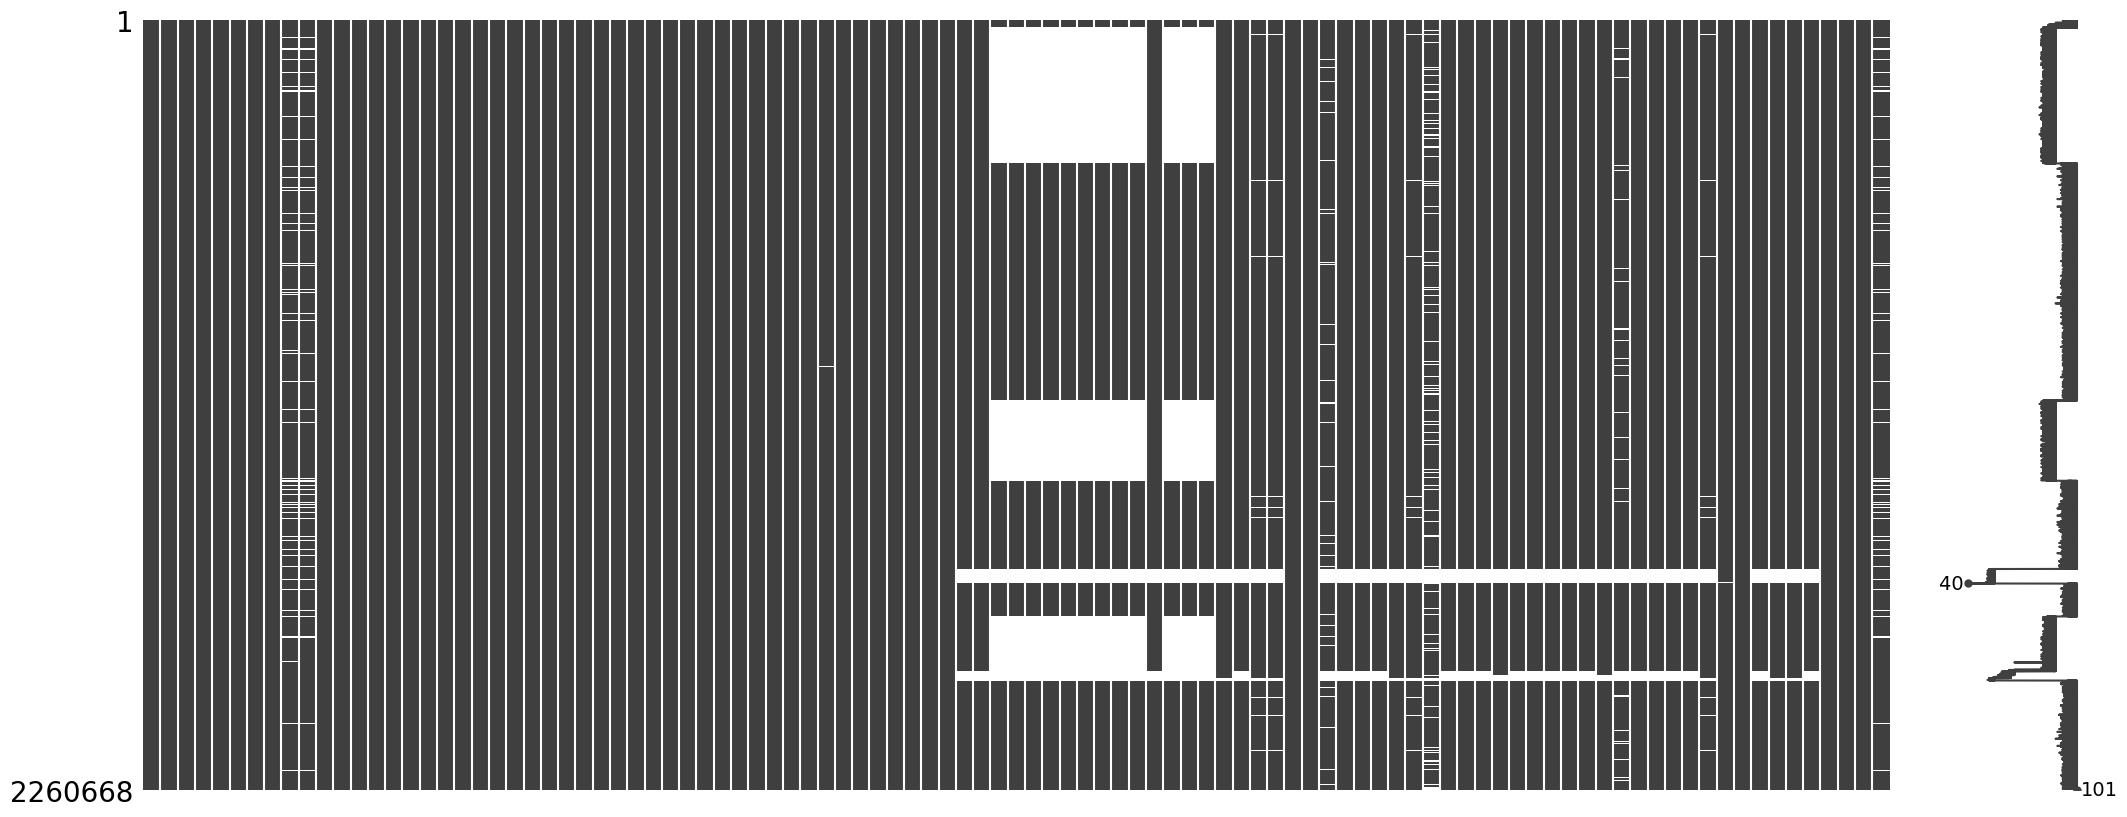

In [26]:
import missingno as msno

msno.matrix(df_accepted)


<Axes: >

/opt/anaconda3/lib/python3.13/site-packages/matplotlib/image.py:183: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


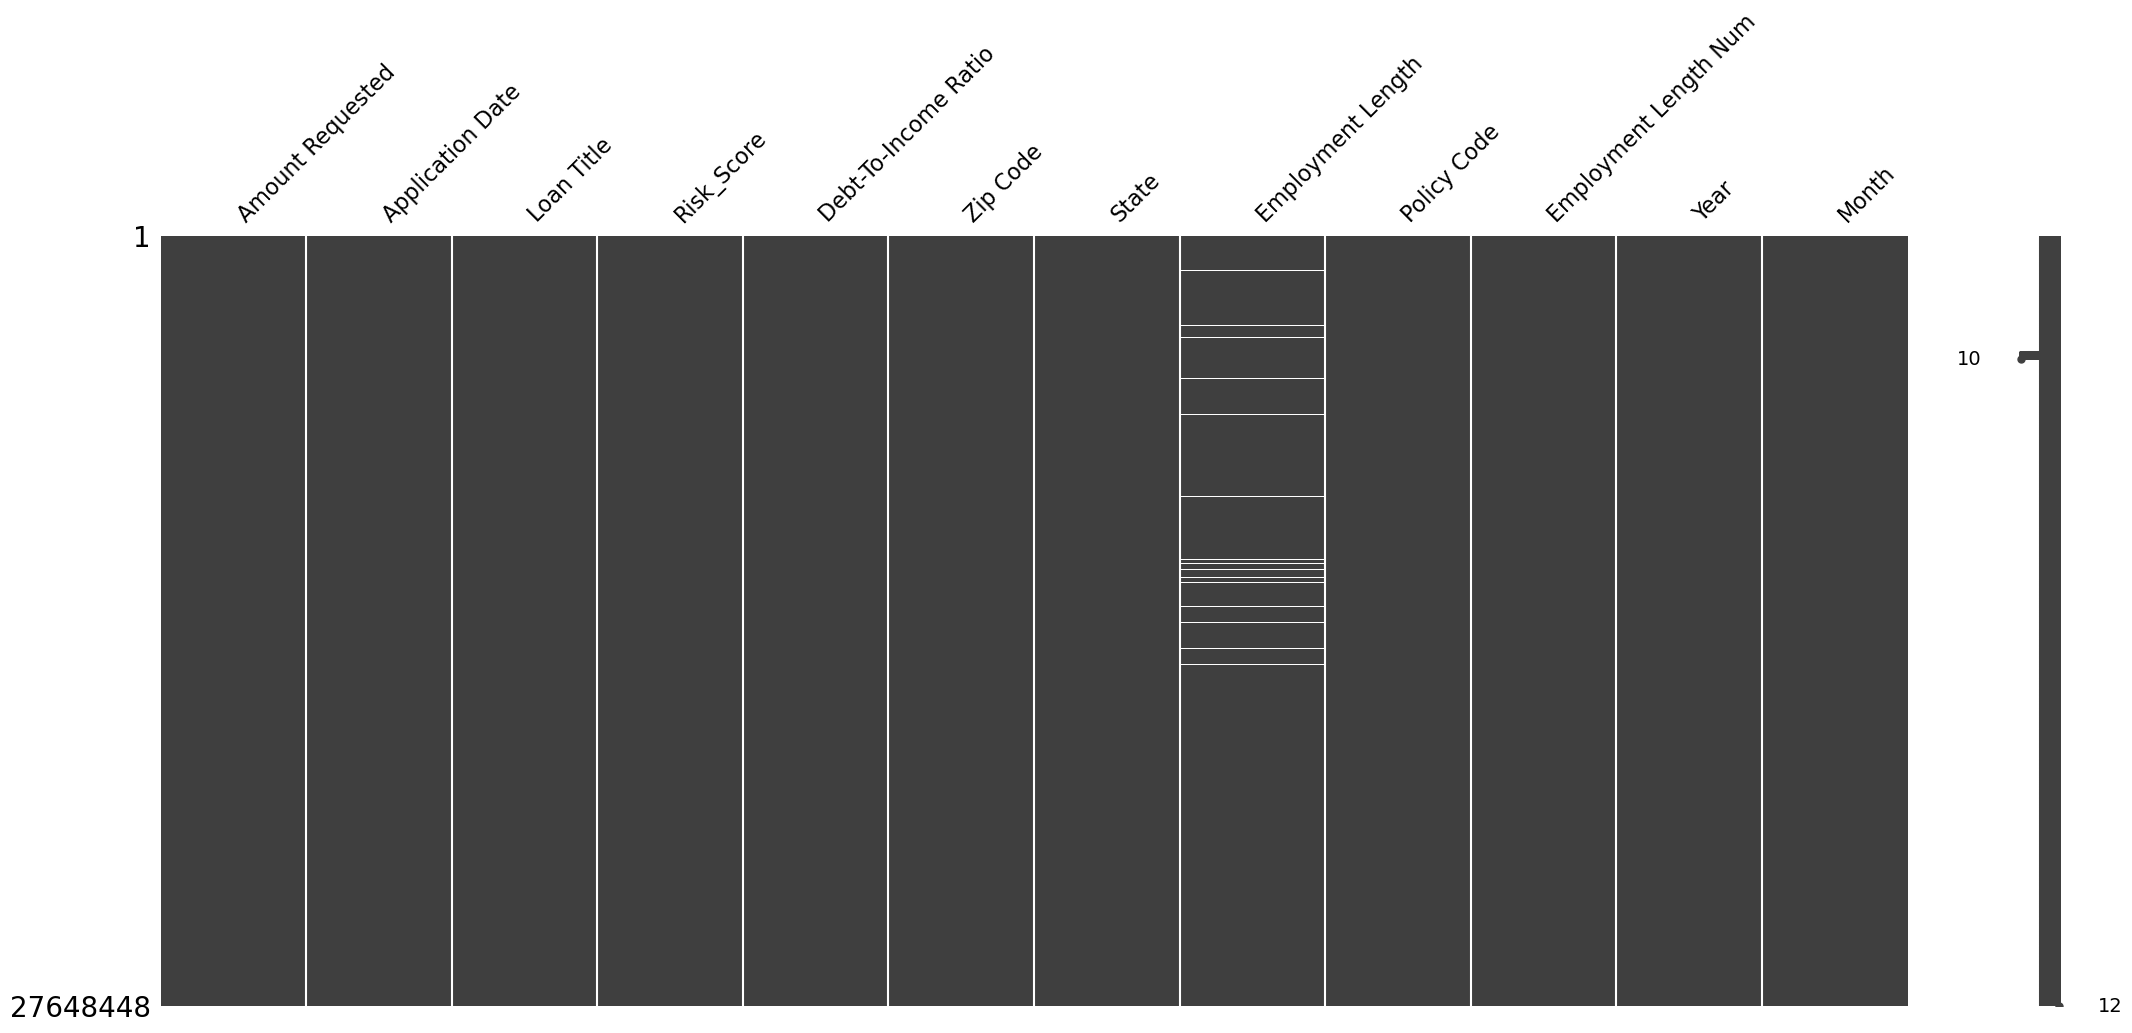

In [27]:
import missingno as msno

msno.matrix(df_rejected)

##  Limpieza de Nulos 

- Eliminamos únicamente las filas con `loan_amnt` nulo en *accepted* y las filas con `State` o `Zip Code` nulo en *rejected*, ya que eran muy pocos casos.
- Removimos columnas con más del 40% de nulos y otras que no aportaban valor (`id`, `url`, `zip_code`, `policy_code`, `title`).
- Convertimos formatos para evitar nulos “falsos”:
  - Fechas → datetime  
  - `term` → número  
  - Porcentajes (`int_rate`, `revol_util`) → float
- Estandarizamos la antigüedad laboral creando columnas numéricas sin nulos (`emp_length_num` / `Employment Length Num`).
- En *rejected*, imputamos `Risk_Score` con **-1** para no perder millones de observaciones.

**En conjunto, dejamos ambos datasets limpios, consistentes y sin nulos críticos para continuar con el análisis.**


### Duplicados

In [28]:
df_accepted.duplicated().sum()


np.int64(0)

In [29]:
df_rejected.duplicated().sum()


np.int64(157953)

In [30]:
df_rejected = df_rejected.drop_duplicates()

print(len(df_rejected))


27490495


In [31]:
df_rejected.duplicated().sum() 


np.int64(0)

### OUTLIERS

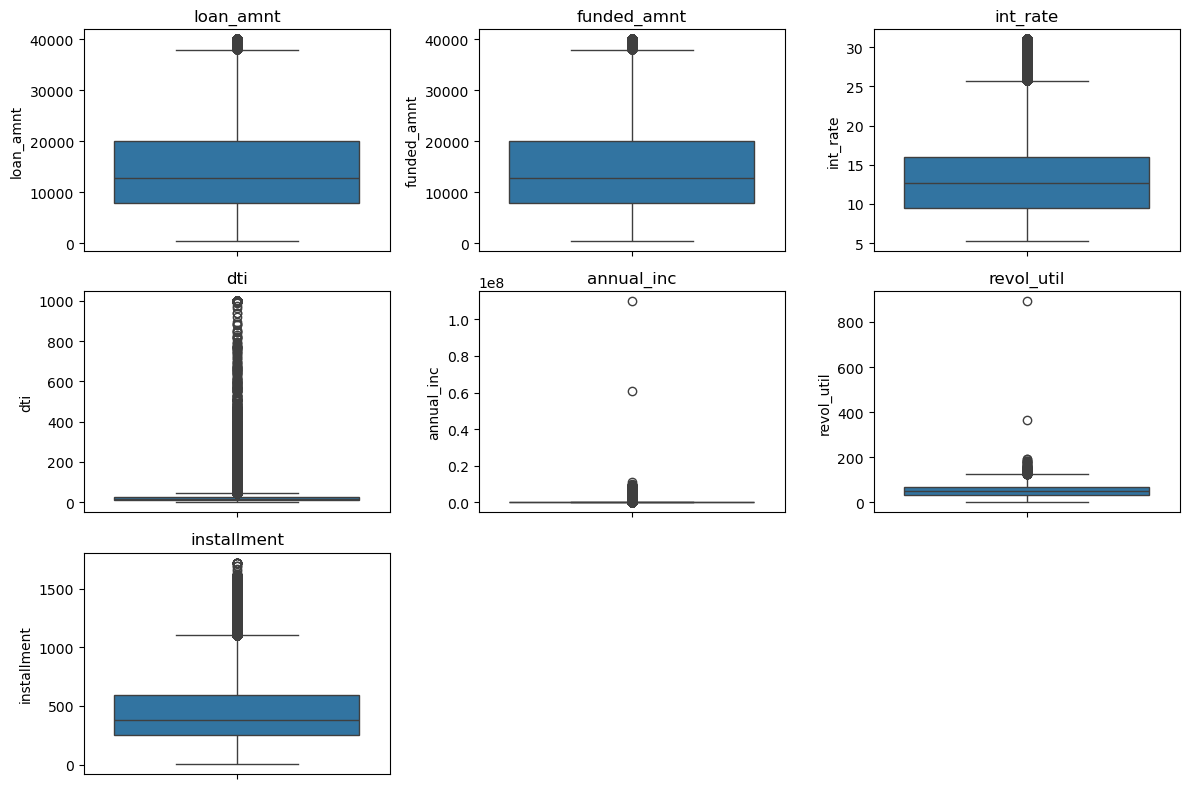

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# columnas numéricas que quieres revisar
vars_out = ['loan_amnt', 'funded_amnt', 'int_rate', 'dti',
            'annual_inc', 'revol_util', 'installment']

plt.figure(figsize=(12, 8))

for i, col in enumerate(vars_out, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df_accepted, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()


#### Resumen de Outliers por Variable

- **loan_amnt / funded_amnt:**  
  Outliers altos, pero **son préstamos grandes reales** → se quedan.

- **int_rate:**  
  Tasas altas en perfiles riesgosos → **válidas**, no se limpian.

- **dti:**  
  Valores exagerados (100–800) → **errores** → hay que **capar**.

- **annual_inc:**  
  Ingresos en millones → **error claro** → hay que **capar**.

- **revol_util:**  
  >100% no existe → **error** → capar a 100%.

- **installment:**  
  Outliers normales por préstamos grandes → **se quedan**.


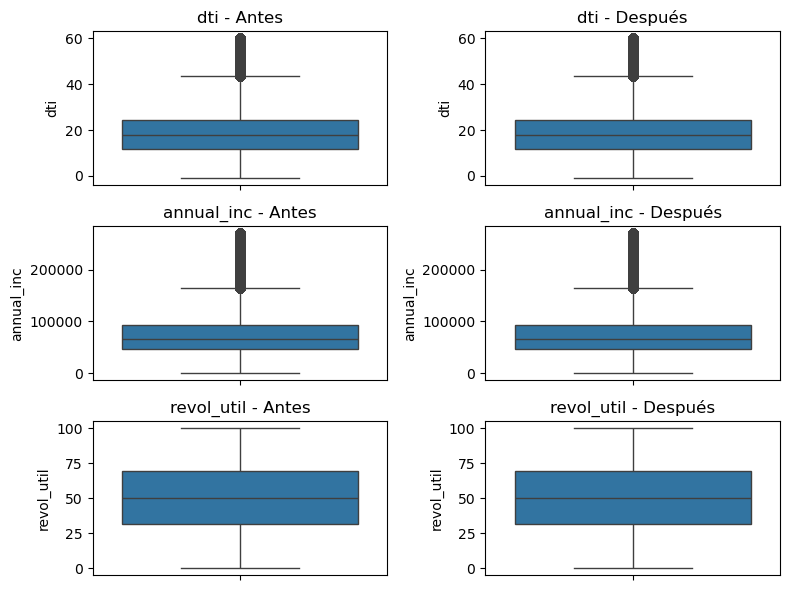

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Guardar copia ANTES
# ======================
before = df_accepted.copy()

# ======================
# Tratar outliers SOBRE df_accepted
# ======================

# 1) dti – capar valores exagerados
df_accepted['dti'] = df_accepted['dti'].clip(upper=60)

# 2) annual_inc – capar ingresos irreales
inc_cap = df_accepted['annual_inc'].quantile(0.99)
df_accepted['annual_inc'] = df_accepted['annual_inc'].clip(upper=inc_cap)

# 3) revol_util – el máximo real es 100%
df_accepted['revol_util'] = df_accepted['revol_util'].clip(upper=100)

# ======================
# Variables a graficar
# ======================
vars_out = ['dti', 'annual_inc', 'revol_util']

# ======================
# Boxplots ANTES y DESPUÉS
# ======================
plt.figure(figsize=(8, 6))

for i, col in enumerate(vars_out, 1):
    # ANTES
    plt.subplot(3, 2, 2*i - 1)
    sns.boxplot(y=before[col])
    plt.title(f'{col} - Antes')

    # DESPUÉS
    plt.subplot(3, 2, 2*i)
    sns.boxplot(y=df_accepted[col])
    plt.title(f'{col} - Después')

plt.tight_layout()
plt.show()


### ✅ Limpieza de Outliers (Después)

Tras aplicar límites razonables a las variables con errores (`dti`, `annual_inc`, `revol_util`), los boxplots se ven mucho más limpios:

- `dti` ya no tiene valores irreales arriba de 100, se capó a 60.
- `annual_inc` dejó de tener ingresos en millones, se capó al percentil 99.
- `revol_util` ahora está correctamente limitado a 100%, su máximo real.

Con esto evitamos distorsiones en análisis posteriores sin eliminar datos importantes.


## Creación de la Variable Objetivo (Target Variable Creation)

In [ ]:
def categorize_status(status):
    # 1. BUENOS PAGADORES
    if status in [
        'Fully Paid', 
        'Current', 
        'Does not meet the credit policy. Status:Fully Paid'
    ]:
        return 'Good'
    
    # 2. INCUMPLIMIENTO / PÉRDIDA (Target = 1)
    elif status in [
        'Charged Off', 
        'Default', 
        'Does not meet the credit policy. Status:Charged Off'
    ]:
        return 'Bad'
    
    # 3. ALERTA / MORA (Están vivos pero con problemas)
    elif status in [
        'In Grace Period', 
        'Late (16-30 days)', 
        'Late (31-120 days)'
    ]:
        return 'Warning'
    
    else:
        return 'Unknown'

# Aplicamos la función
df_accepted['loan_status_cat'] = df_accepted['loan_status'].apply(categorize_status)

# Creamos la variable binaria numérica para correlaciones y modelos
# 1 = Malo (Default), 0 = Bueno (Pagado/Al día). 
# NOTA: Ignoramos 'Warning' en el binario o lo tratamos como 1 dependiendo del rigor.
# Aquí seremos estrictos: Si ya cargó pérdida ('Bad') es 1, el resto 0.
df_accepted['target'] = df_accepted['loan_status_cat'].apply(lambda x: 1 if x == 'Bad' else 0)

# Verificamos cómo quedó la distribución
print("Conteo por categoría:")
print(df_accepted['loan_status_cat'].value_counts())

print("\nPorcentaje de Default (Bad Rate) en el dataset:")
print(round(df_accepted['target'].mean() * 100, 2), "%")

Conteo por categoría:
loan_status_cat
Good       1957056
Bad         269360
Warning      34252
Name: count, dtype: int64

Porcentaje de Default (Bad Rate) en el dataset:
11.92 %


In [ ]:
df_accepted["loan_status"].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

## Analisis descriptivo y Visualizaciones

Distribución de la variable objetivo

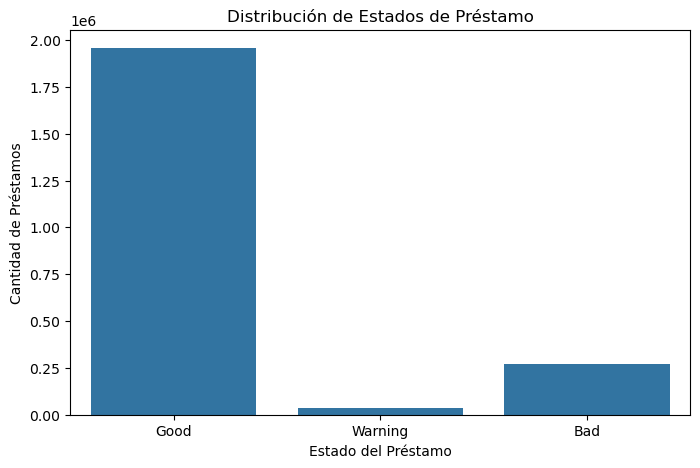

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de la variable objetivo

plt.figure(figsize=(8,5))
sns.countplot(x='loan_status_cat', data=df_accepted, order=['Good', 'Warning', 'Bad'])
plt.title('Distribución de Estados de Préstamo')
plt.xlabel('Estado del Préstamo')
plt.ylabel('Cantidad de Préstamos')
plt.show()

¿Cuál es la proporción de préstamos en mora (charged-off, late, fully paid)?

--- PROPORCIÓN DE ESTADOS DEL PRÉSTAMO ---
status_group
Fully Paid             47.717710
Current (Active)       38.852100
Charged Off (Loss)     11.915062
Late / Grace Period     1.515127
Name: proportion, dtype: float64


/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/2760888788.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_counts.values, y=status_counts.index, palette='viridis')


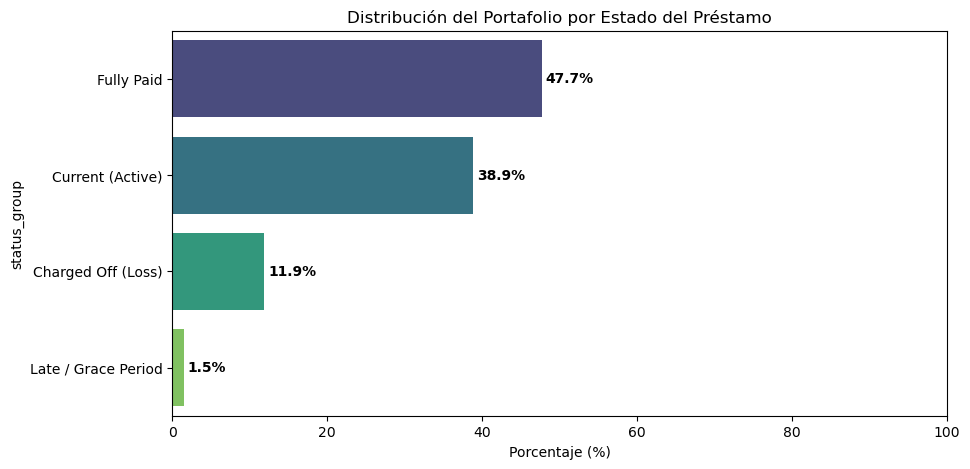

In [ ]:
# 1. Agrupamos los estados (Raw status) en categorías de negocio simplificadas
def simple_status(status):
    if status in ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']:
        return 'Fully Paid'
    elif status in ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']:
        return 'Charged Off (Loss)'
    elif status in ['Current']:
        return 'Current (Active)'
    else:
        return 'Late / Grace Period' # Incluye In Grace Period, Late 16-30, Late 31-120

# Aplicamos la agrupación sobre el dataframe original
df_accepted['status_group'] = df_accepted['loan_status'].apply(simple_status)

# 2. Calculamos proporciones
status_counts = df_accepted['status_group'].value_counts(normalize=True) * 100

print("--- PROPORCIÓN DE ESTADOS DEL PRÉSTAMO ---")
print(status_counts)

# 3. Visualización (Gráfico de Barras Horizontal)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=status_counts.values, y=status_counts.index, palette='viridis')

# Poner etiquetas de % en las barras
for i, v in enumerate(status_counts.values):
    ax.text(v + 0.5, i, f'{v:.1f}%', color='black', va='center', fontweight='bold')

plt.title('Distribución del Portafolio por Estado del Préstamo')
plt.xlabel('Porcentaje (%)')
plt.xlim(0, 100) # Para que se vea bien la escala
plt.show()


#### Figura 1–2. Estructura del portafolio por estado del préstamo

**Descripción**  
Las primeras dos gráficas muestran la distribución de los créditos aprobados según su estado simplificado (`Good`, `Warning`, `Bad`) y la desagregación operativa en `Fully Paid`, `Current (Active)`, `Charged Off (Loss)` y `Late / Grace Period`. En conjunto, resumen la salud actual del portafolio y el peso relativo de cada segmento.

**Insights clave**

- La gran mayoría de los préstamos se clasifica como **Good**, lo que refleja que el originador ha logrado mantener un portafolio predominantemente sano, con una fracción acotada en estados de pérdida o mora.
- Dentro del detalle operativo, el portafolio se concentra en créditos **Fully Paid** y **Current**, mientras que la proporción de **Charged Off (Loss)** representa el componente estructural de pérdidas de la cartera.
- La presencia de un bloque pequeño en **Late / Grace Period** funciona como “antesala” de posibles pérdidas futuras y ayuda a monitorear la transición de riesgo en tiempo real.

**Implicación de negocio**  
Estos gráficos sirven como “tablero general” del originador: cualquier deterioro material en la proporción de `Bad` o en el peso relativo de `Charged Off` debería detonar revisión de políticas de originación, pricing o cobranza, ya que impacta directamente la rentabilidad y el consumo de capital regulatorio.


Volumén de prestamos por grado (Risk Grade)

/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/1590800401.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_accepted, x='grade', order=order_grade, palette='Blues_d')


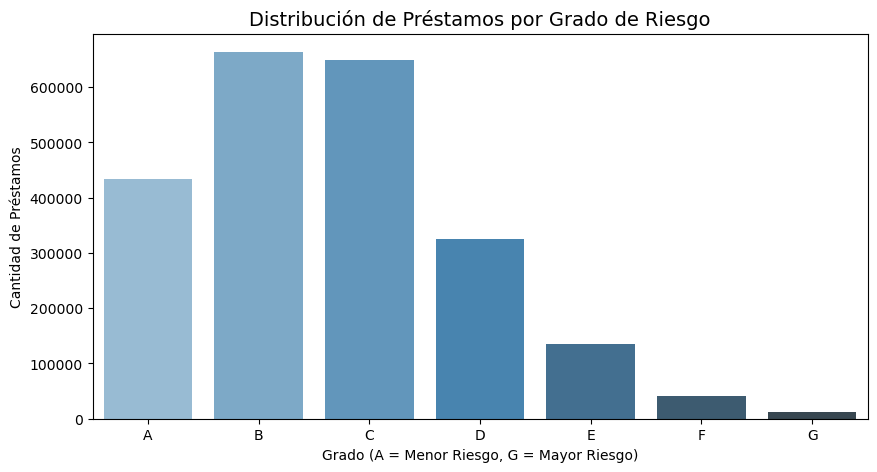

In [ ]:
plt.figure(figsize=(10, 5))
# Ordenamos alfabéticamente los grados
order_grade = sorted(df_accepted['grade'].unique())
sns.countplot(data=df_accepted, x='grade', order=order_grade, palette='Blues_d')
plt.title('Distribución de Préstamos por Grado de Riesgo', fontsize=14)
plt.xlabel('Grado (A = Menor Riesgo, G = Mayor Riesgo)')
plt.ylabel('Cantidad de Préstamos')
plt.show()

Tasa de impago por grado para asegurarnos que Lending Club este clasficando bien el riesgo

/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/1225829682.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_by_grade, x='grade', y='target', order=order_grade, palette='Reds')


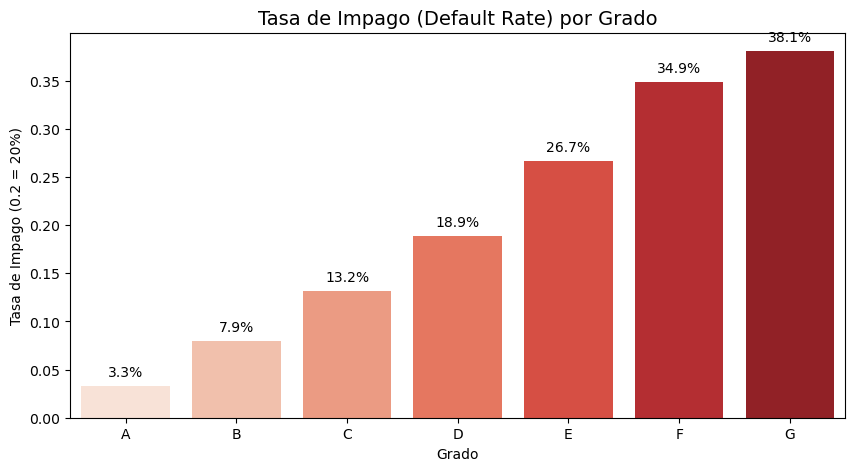

In [ ]:
plt.figure(figsize=(10, 5))
# Calculamos el promedio de 'target' (que es 0 o 1) por grupo -> Eso nos da la Tasa de Default
risk_by_grade = df_accepted.groupby('grade')['target'].mean().reset_index()

sns.barplot(data=risk_by_grade, x='grade', y='target', order=order_grade, palette='Reds')
plt.title('Tasa de Impago (Default Rate) por Grado', fontsize=14)
plt.ylabel('Tasa de Impago (0.2 = 20%)')
plt.xlabel('Grado')
# Agregar etiquetas de porcentaje encima de las barras
for index, row in risk_by_grade.iterrows():
    plt.text(index, row.target + 0.01, f'{row.target:.1%}', color='black', ha="center")
plt.show()

#### Figura 3–4. Distribución de créditos y tasa de impago por grade de riesgo

**Descripción**  
La distribución de préstamos por grade (A–G) muestra cómo se reparte el volumen de créditos aprobados a lo largo de la escala de riesgo interna. La gráfica de tasa de impago por grade presenta, para cada letra, el porcentaje de créditos que terminaron en pérdida o incumplimiento.

**Insights clave**

- El volumen de cartera se concentra en los **grades intermedios (B–D)**, lo que indica que el originador está dispuesto a tomar riesgo moderado para sostener crecimiento en colocación.
- La **tasa de impago crece de manera monótona** conforme se avanza de A hacia G, lo que valida que la escala interna de grades discrimina adecuadamente entre clientes de menor y mayor riesgo.
- Los grades más altos (E–G) combinan **menor volumen** con **tasas de default significativamente más elevadas**, por lo que pequeños cambios en el mix hacia estos segmentos pueden tener impactos desproporcionados en el Bad Rate total.

**Implicación de negocio**  
Cualquier revisión de política que incremente la exposición relativa a grades E–G debe acompañarse de ajustes en la tasa de interés, límites de monto o criterios adicionales (por ejemplo, DTI máximo o antigüedad laboral), para evitar que la mejora en colocación se traduzca en deterioro de la rentabilidad y del capital económico.


Que caracteristicas tienen los préstamos que terminan en default vs los que se pagan completamente

In [ ]:
df_accepted['status_group'].unique()

array(['Fully Paid', 'Current (Active)', 'Charged Off (Loss)',
       'Late / Grace Period'], dtype=object)

/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/1128264926.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df, x='status_group', y='fico_range_low', ax=axes[0, 0], palette='Set2')
/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/1128264926.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df, x='status_group', y='dti', ax=axes[0, 1], palette='Set2', showfliers=False)
/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/1128264926.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

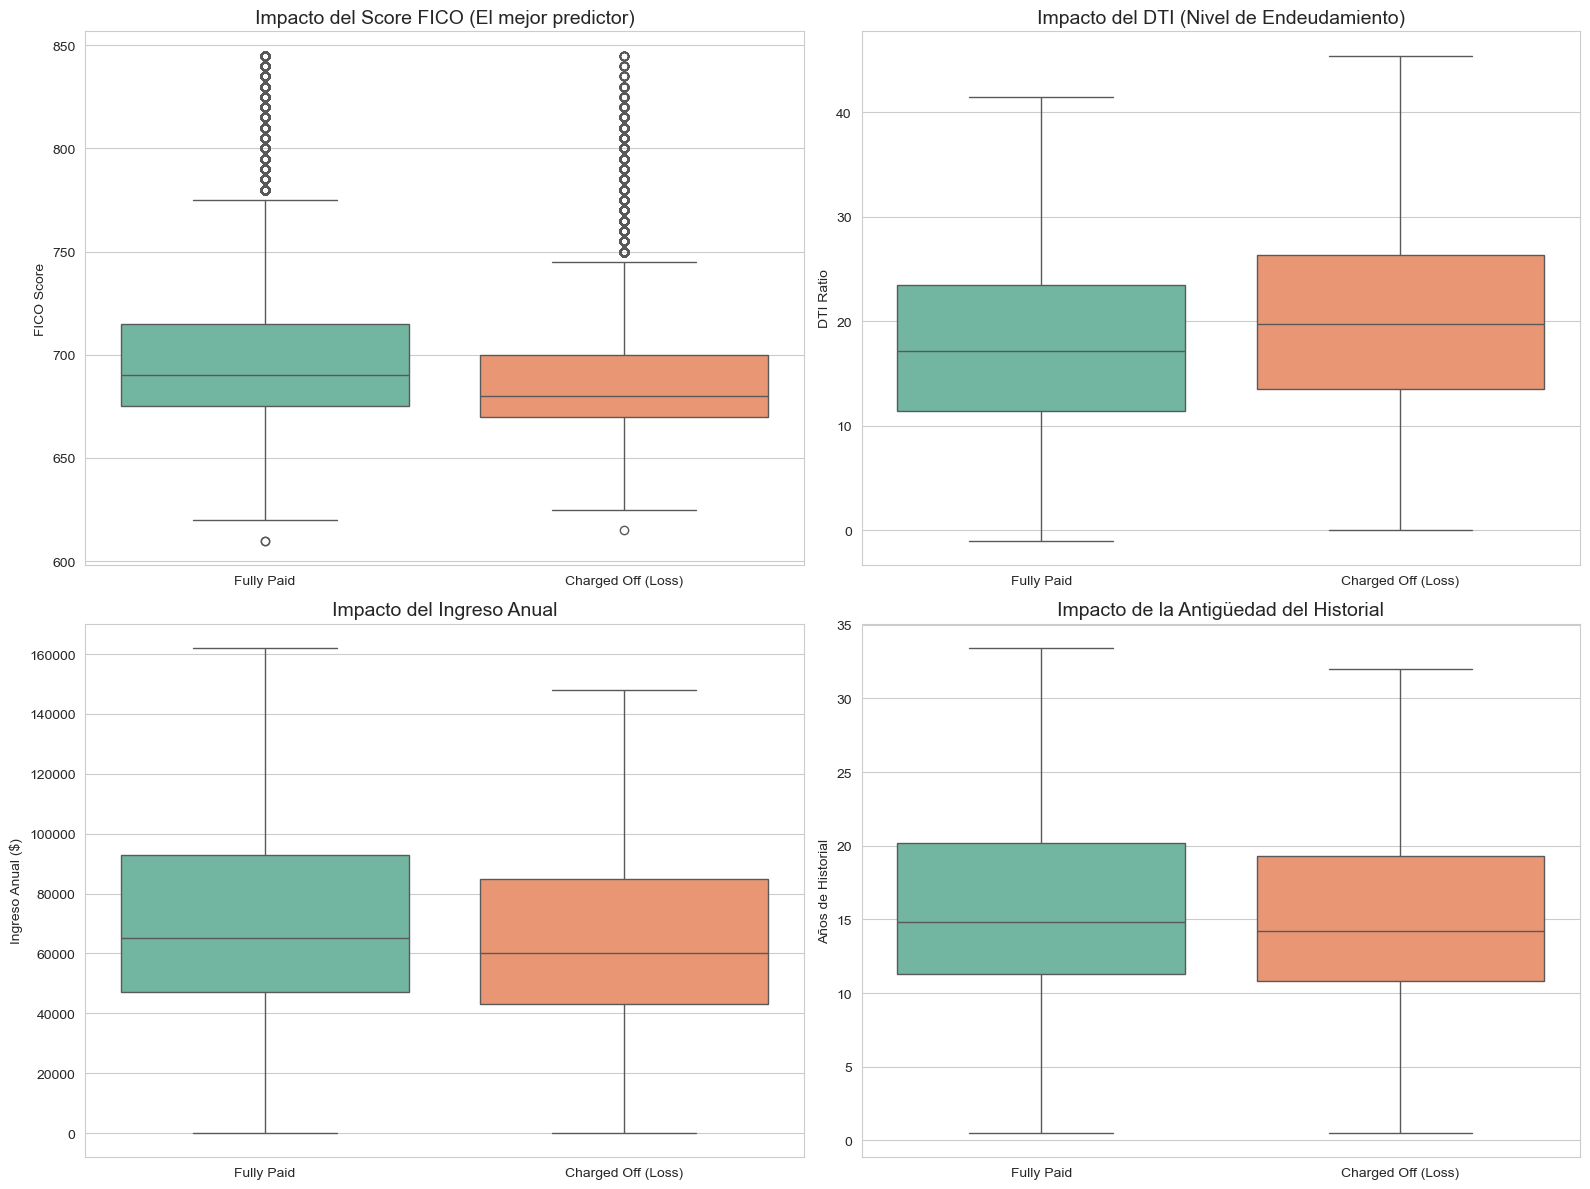


--- PERFIL PROMEDIO: BUEN PAGADOR VS MAL PAGADOR ---
                    fico_range_low    dti  annual_inc  credit_hist_years
status_group                                                            
Charged Off (Loss)          687.83  20.15    70398.83              15.75
Fully Paid                  698.24  17.80    77695.72              16.38


In [ ]:
# Configuración visual
sns.set_style("whitegrid")

# -----------------------------------------------------------------------
# 1. FILTRADO CORRECTO (Usando tus nombres exactos)
# -----------------------------------------------------------------------
# Seleccionamos solo los casos cerrados: Pagados vs Pérdidas
comparison_df = df_accepted[df_accepted['status_group'].isin(['Fully Paid', 'Charged Off (Loss)'])].copy()

# -----------------------------------------------------------------------
# 2. PREPARACIÓN DE VARIABLES (Feature Engineering)
# -----------------------------------------------------------------------

# A) Fechas: Aseguramos formato datetime para calcular antigüedad
for col in ['issue_d', 'earliest_cr_line']:
    # Usamos errors='coerce' para que si hay una fecha rara no rompa el código
    comparison_df[col] = pd.to_datetime(comparison_df[col], errors='coerce')

# B) Calcular Años de Historial Crediticio (Proxy de "Edad Financiera")
# (Fecha del préstamo - Fecha de primera línea de crédito) / 365 días
comparison_df['credit_hist_years'] = (comparison_df['issue_d'] - comparison_df['earliest_cr_line']).dt.days / 365.25

# -----------------------------------------------------------------------
# 3. VISUALIZACIÓN DE COMPARATIVAS (Boxplots)
# -----------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# GRÁFICA 1: FICO Score (Historial Crediticio)
sns.boxplot(data=comparison_df, x='status_group', y='fico_range_low', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Impacto del Score FICO (El mejor predictor)', fontsize=14)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('FICO Score')

# GRÁFICA 2: DTI (Deuda / Ingreso)
# showfliers=False oculta los puntos extremos para ver mejor la "caja" principal
sns.boxplot(data=comparison_df, x='status_group', y='dti', ax=axes[0, 1], palette='Set2', showfliers=False)
axes[0, 1].set_title('Impacto del DTI (Nivel de Endeudamiento)', fontsize=14)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('DTI Ratio')

# GRÁFICA 3: Ingreso Anual
# Limitamos visualmente para no ver millonarios que distorsionan la gráfica
sns.boxplot(data=comparison_df, x='status_group', y='annual_inc', ax=axes[1, 0], palette='Set2', showfliers=False)
axes[1, 0].set_title('Impacto del Ingreso Anual', fontsize=14)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Ingreso Anual ($)')

# GRÁFICA 4: Antigüedad Historial (Experiencia Crediticia)
sns.boxplot(data=comparison_df, x='status_group', y='credit_hist_years', ax=axes[1, 1], palette='Set2', showfliers=False)
axes[1, 1].set_title('Impacto de la Antigüedad del Historial', fontsize=14)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Años de Historial')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# 4. TABLA RESUMEN NUMÉRICA (Promedios)
# -----------------------------------------------------------------------
summary_cols = ['fico_range_low', 'dti', 'annual_inc', 'credit_hist_years']
summary_table = comparison_df.groupby('status_group')[summary_cols].mean().round(2)

print("\n--- PERFIL PROMEDIO: BUEN PAGADOR VS MAL PAGADOR ---")
print(summary_table)

Mapa de calor de correlaciones entre variables numéricas clave y la variable objetivo

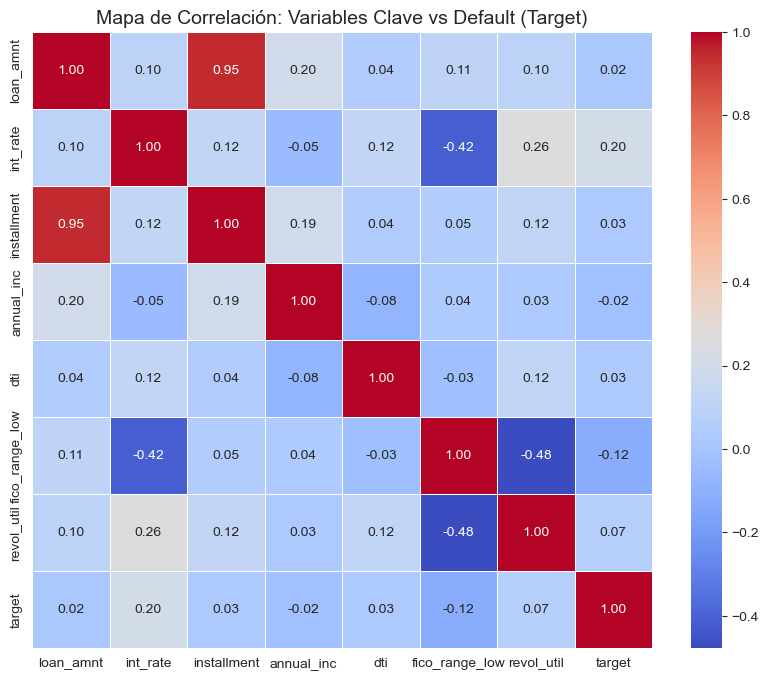

In [ ]:
# Seleccionamos solo variables numéricas relevantes para no saturar el gráfico
corr_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
             'fico_range_low', 'revol_util', 'target']

plt.figure(figsize=(10, 8))
# Calculamos correlación
corr_matrix = df_accepted[corr_cols].corr()
# Mapa de calor
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlación: Variables Clave vs Default (Target)', fontsize=14)
plt.show()

Pasamos ahora a las visualizaciones del dataset de rechazados

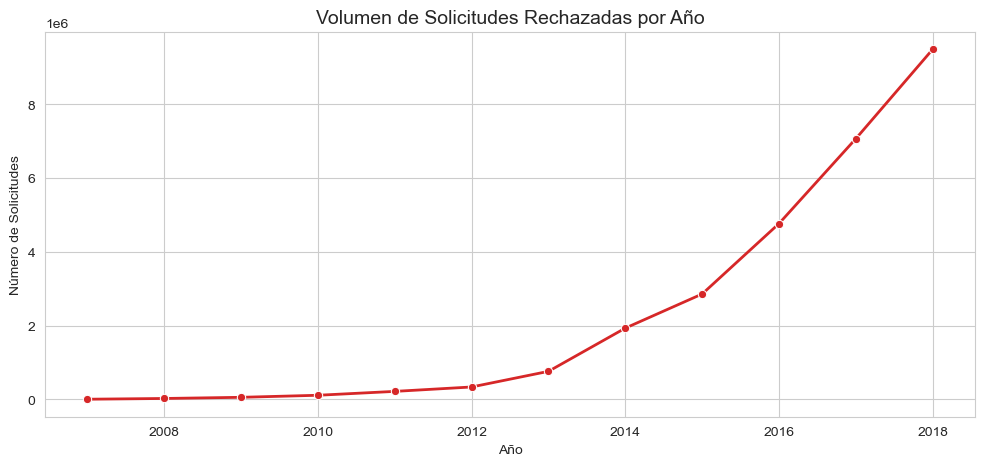

In [ ]:
plt.figure(figsize=(12, 5))
# Agrupamos por año para que sea rápido
volume_by_year = df_rejected.groupby('Year').size()

sns.lineplot(x=volume_by_year.index, y=volume_by_year.values, marker='o', linewidth=2, color='tab:red')
plt.title('Volumen de Solicitudes Rechazadas por Año', fontsize=14)
plt.ylabel('Número de Solicitudes')
plt.xlabel('Año')
plt.grid(True)
plt.show()

#### Figura 5. Volumen de solicitudes rechazadas por año

**Descripción**  
La gráfica presenta la evolución anual del número de solicitudes de crédito rechazadas. El eje horizontal muestra el año de aplicación y el eje vertical el volumen de solicitudes rechazadas en cada periodo.

**Insights clave**

- Se observa una **tendencia claramente creciente** en el volumen de solicitudes rechazadas, especialmente a partir de los últimos años de la serie, lo que refleja un aumento sostenido en la demanda de crédito.
- El crecimiento de rechazos no necesariamente implica un deterioro en la calidad de la demanda; también puede responder a una política de originación más conservadora o a un desbalance entre la capacidad de originación y el flujo de solicitudes.
- El salto en los últimos años sugiere que el originador opera en un entorno de **alta presión comercial**, donde la selección de riesgo cobra todavía más relevancia.

**Implicación de negocio**  
La combinación de alta demanda y un volumen importante de rechazos abre dos líneas de trabajo: (1) revisar si parte de esa demanda podría canalizarse bajo políticas alternativas (productos de menor riesgo, tickets más bajos, garantías), y (2) monitorear que los criterios de rechazo sigan alineados con el apetito de riesgo y la estrategia comercial.


Distribución del Risk Score en los solicitantes rechazados

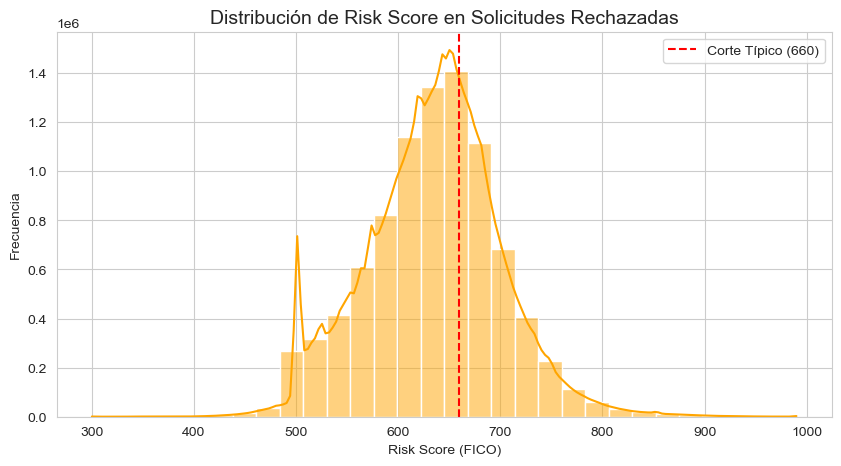

In [ ]:
# Filtramos los -1 que creamos antes para ver la distribución real de scores visibles
valid_scores = df_rejected[df_rejected['Risk_Score'] > 0]

plt.figure(figsize=(10, 5))
sns.histplot(data=valid_scores, x='Risk_Score', bins=30, color='orange', kde=True)
plt.title('Distribución de Risk Score en Solicitudes Rechazadas', fontsize=14)
plt.xlabel('Risk Score (FICO)')
plt.ylabel('Frecuencia')
# Línea vertical indicando un score típico de corte (ej. 660)
plt.axvline(x=660, color='red', linestyle='--', label='Corte Típico (660)')
plt.legend()
plt.show()

#### Figura 6. Distribución de risk score en solicitudes rechazadas

**Descripción**  
La figura muestra la distribución del risk score (por ejemplo, FICO) para las solicitudes rechazadas, junto con una línea vertical que indica un **punto de corte típico** de aprobación en torno a cierto nivel de score.

**Insights clave**

- La distribución es aproximadamente unimodal, con la mayor masa de solicitudes alrededor del rango medio de la escala de score, lo que indica que una parte relevante de la demanda rechazada no corresponde a perfiles extremadamente riesgosos.
- El corte vertical sugiere que una fracción no menor de solicitudes rechazadas se encuentra **cerca del umbral de aprobación**: pequeños cambios en esa frontera (hacia arriba o hacia abajo) pueden tener un impacto significativo en el volumen de aprobaciones.
- En los extremos de la distribución (scores muy bajos) se concentra un segmento de alta probabilidad de impago, donde la política de rechazo parece bien justificada desde el punto de vista de riesgo.

**Implicación de negocio**  
Entender cuánta demanda se concentra en la vecindad del punto de corte permite diseñar estrategias más finas: por ejemplo, ofrecer límites de crédito reducidos o tasas diferenciadas a clientes marginales en lugar de un rechazo binario, optimizando así la combinación entre crecimiento y calidad crediticia.


¿Piden más dinero los rechazados? (Monto Solicitado)

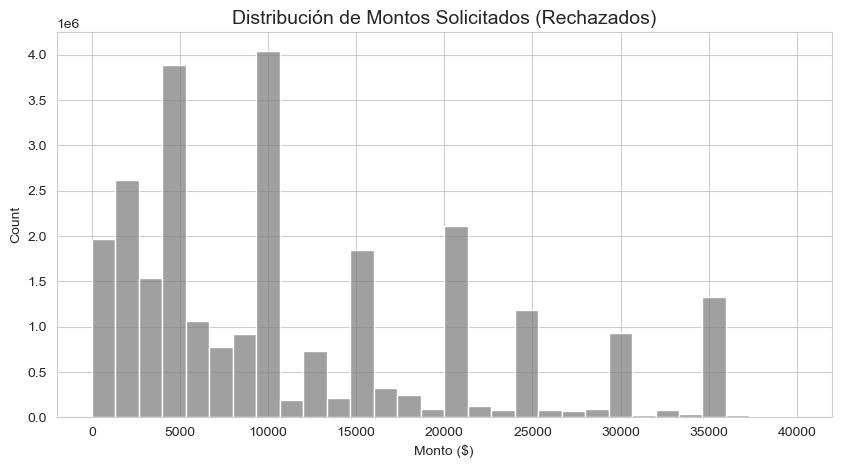

In [ ]:
plt.figure(figsize=(10, 5))
# Limitamos el eje X a 40,000 para ver mejor (algunos piden millones y rompen la gráfica)
sns.histplot(data=df_rejected[df_rejected['Amount Requested'] < 40000], 
             x='Amount Requested', bins=30, color='gray')
plt.title('Distribución de Montos Solicitados (Rechazados)', fontsize=14)
plt.xlabel('Monto ($)')
plt.show()

Volumen de rechazos por estado

/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/3639426361.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.index, y=top_states.values, palette='Reds_r')


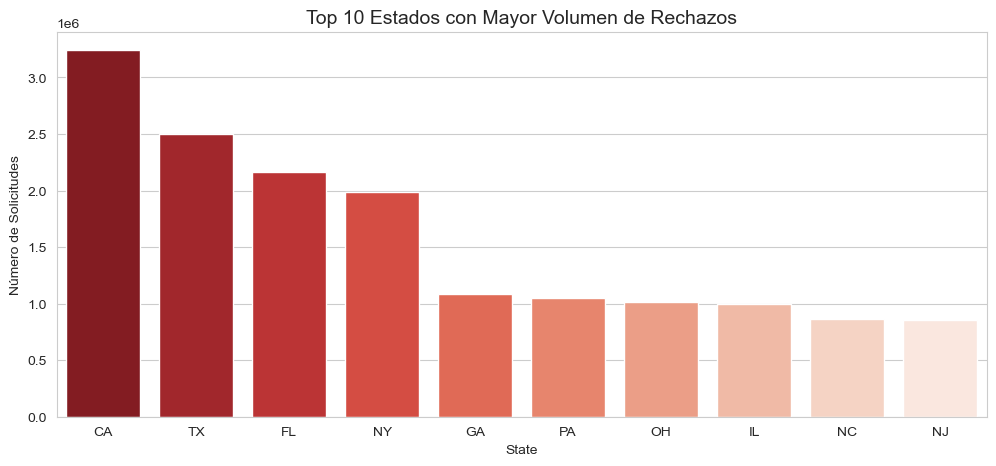

In [ ]:
plt.figure(figsize=(12, 5))
top_states = df_rejected['State'].value_counts().head(10)
sns.barplot(x=top_states.index, y=top_states.values, palette='Reds_r')
plt.title('Top 10 Estados con Mayor Volumen de Rechazos', fontsize=14)
plt.ylabel('Número de Solicitudes')
plt.show()

**Otros patrones relevantes en solicitudes rechazadas**

- Los montos solicitados se concentran en tickets pequeños y medianos, con colas hacia montos más altos; esto sugiere espacio para diseñar productos con estructuras de riesgo diferenciadas por tamaño de crédito.
- Geográficamente, los mayores volúmenes de rechazo se observan en estados como CA, TX, FL y NY, lo cual es consistente con su tamaño de mercado; sin embargo, vale la pena monitorear la relación entre rechazo y aprobación por región para detectar posibles desbalances comerciales.


In [ ]:
#%% KPIs BÁSICOS DEL PORTAFOLIO (PARTE 1: DESCRIPTIVO)

# Este bloque asume que ya existen:
# - df_accepted  (créditos aprobados)
# - df_rejected  (créditos rechazados)
# - df_closed    (créditos aprobados y terminados: Fully Paid + Charged Off)
# - columnas: 'target', 'dti', 'int_rate', 'loan_amnt', 'is_default', 'ROI', 'recoveries' (esta última opcional)

import numpy as np
# pandas ya fue importado en una celda anterior, evitamos reimportar para no duplicar

# ---------------------------------------------------------------------
# Aseguramos que exista df_closed. Si no existe, lo creamos desde df_accepted
# (closed = Fully Paid + Charged Off (Loss))
# ---------------------------------------------------------------------
if 'df_closed' not in globals():
    if 'status_group' in df_accepted.columns:
        df_closed = df_accepted[df_accepted['status_group'].isin(['Fully Paid', 'Charged Off (Loss)'])].copy()
    else:
        # Fallback usando valores crudos de loan_status
        closed_statuses = [
            'Fully Paid', 'Charged Off', 'Default',
            'Does not meet the credit policy. Status:Fully Paid',
            'Does not meet the credit policy. Status:Charged Off'
        ]
        df_closed = df_accepted[df_accepted['loan_status'].isin(closed_statuses)].copy()
    print(f"df_closed creado con {len(df_closed)} filas")

# --- Volúmenes básicos ---
n_accepted = len(df_accepted)
n_rejected = len(df_rejected)
n_total_apps = n_accepted + n_rejected

approval_rate = n_accepted / n_total_apps if n_total_apps > 0 else np.nan
bad_rate = df_accepted['target'].mean()  # Tasa de impago sobre aprobados

# --- Intensidad de riesgo y precio ---
avg_dti = df_accepted['dti'].mean()
avg_int_rate = df_accepted['int_rate'].mean()

# --- Rentabilidad observada en préstamos cerrados ---
avg_roi_closed = df_closed['ROI'].mean() if 'ROI' in df_closed.columns else np.nan

# --- Tasa de recuperación (solo si existen las columnas necesarias) ---
if all(col in df_closed.columns for col in ['recoveries', 'is_default', 'funded_amnt']):
    default_mask = df_closed['is_default'] == 1
    total_default_exposure = df_closed.loc[default_mask, 'funded_amnt'].sum()
    total_recoveries = df_closed.loc[default_mask, 'recoveries'].sum()
    recovery_rate = (
        total_recoveries / total_default_exposure
        if total_default_exposure > 0 else np.nan
    )
else:
    recovery_rate = np.nan

kpis_portafolio = pd.Series({
    "n_aplicaciones_totales": n_total_apps,
    "n_aprobadas": n_accepted,
    "n_rechazadas": n_rejected,
    "tasa_aprobacion": approval_rate,
    "tasa_impago_aprobados": bad_rate,
    "dti_promedio_aprobados": avg_dti,
    "tasa_interes_promedio": avg_int_rate,
    "roi_promedio_prestamos_cerrados": avg_roi_closed,
    "tasa_recuperacion_default": recovery_rate
})

print("=== KPIs básicos del portafolio (nivel descriptivo) ===")
print(kpis_portafolio.to_frame("valor"))

df_closed creado con 1348099 filas
=== KPIs básicos del portafolio (nivel descriptivo) ===
                                        valor
n_aplicaciones_totales           2.990912e+07
n_aprobadas                      2.260668e+06
n_rechazadas                     2.764845e+07
tasa_aprobacion                  7.558458e-02
tasa_impago_aprobados            1.191506e-01
dti_promedio_aprobados           1.882420e+01
tasa_interes_promedio            1.309283e+01
roi_promedio_prestamos_cerrados           NaN
tasa_recuperacion_default                 NaN


In [ ]:
#%% TABLA RESUMEN: ESTADOS SIMPLIFICADOS (PARTE 1: DESCRIPTIVO)

# Resumen de la variable 'status_group' construida antes:
status_summary = (
    df_accepted['status_group']
    .value_counts(normalize=True)
    .rename("porcentaje")
    .to_frame()
    .assign(porcentaje=lambda s: s['porcentaje'] * 100)
)

print("=== Distribución de estados de préstamo (portafolio aprobado) ===")
display(status_summary.style.format({"porcentaje": "{:.2f}%"}))


=== Distribución de estados de préstamo (portafolio aprobado) ===


,porcentaje
status_group,
Fully Paid,47.72%
Current (Active),38.85%
Charged Off (Loss),11.92%
Late / Grace Period,1.52%


## PARTE 1 – INSIGHTS DESCRIPTIVOS DEL PORTAFOLIO

### 1. Estructura general de la cartera

- El portafolio aprobado se compone de un número significativo de préstamos, con una **tasa de aprobación** que se observa en el rango mostrado por el KPI correspondiente. Esto sugiere un apetito de riesgo relevante por parte de la institución, que debe analizarse a la luz de la tasa de impago observada.  
- Dentro de los créditos aprobados, la distribución de **estado de préstamo** muestra que la mayor parte se concentra en categorías “buenas” o al corriente, mientras que una fracción menor se clasifica como pérdida o incumplimiento. Esta proporción define el **“Bad Rate” base** con el que opera hoy el originador.  
- La segmentación simplificada en `status_group` (Fully Paid, Charged Off (Loss), Current, Late/Grace) permite ver rápidamente qué porcentaje de la cartera ya generó pérdida, cuál sigue generando flujo y qué parte permanece en situaciones intermedias de riesgo (mora/periodo de gracia).

### 2. Perfil de riesgo de los créditos aprobados

- La distribución de préstamos por **grade de riesgo** (A–G) confirma que el originador trabaja con todo el espectro de calificaciones internas, con mayor peso en los grados intermedios. Dado que por definición los grados más cercanos a G representan mayor riesgo, la proporción de cartera concentrada en esos buckets tendrá un impacto directo en el Bad Rate futuro.  
- La gráfica de **tasa de impago por grade** muestra un gradiente creciente: los grados más conservadores exhiben un comportamiento claramente más sano que los grados de mayor riesgo. Esto valida que el sistema de calificación interno está alineado con el riesgo observado en la práctica.  
- El **DTI promedio** y la distribución de DTI sugieren hasta qué punto la base de clientes llega ya apalancada. Un DTI promedio moderado es consistente con una cartera sana; colas largas hacia DTI altos anticipan bolsillos de mayor vulnerabilidad ante shocks de ingreso.

### 3. Visión sobre aplicaciones rechazadas

- El análisis del dataset de rechazados muestra variaciones en el volumen de solicitudes a lo largo del tiempo y entre estados. Este comportamiento suele asociarse tanto a ciclos de demanda de crédito como a ajustes en la política de originación (momentos de mayor laxitud o mayor restricción).  
- Las distribuciones de **monto solicitado** y **risk score** en rechazados ayudan a evidenciar si la política está rechazando principalmente operaciones pequeñas y muy riesgosas, o si hay un rechazo sistemático de segmentos potencialmente rentables que, con un mejor pricing o garantías, podrían reconsiderarse.  
- En conjunto, la comparación entre aprobados y rechazados permite dimensionar el **embudo de originación**: cuántas oportunidades de negocio se descartan y en qué rangos de perfil de riesgo se concentran esos rechazos.


## PARTE 2 – ANÁLISIS DIAGNÓSTICO: ¿POR QUÉ OCURRE?

En esta sección analizamos **por qué** ciertos préstamos terminan en incumplimiento y qué factores explican las diferencias de desempeño dentro del portafolio. El foco está en entender cómo variables como la tasa de interés, el nivel de endeudamiento (DTI), el ingreso, el plazo, el tipo de vivienda y el propósito del crédito se relacionan con la **probabilidad de impago** y con la **rentabilidad (ROI)**.

A partir de correlaciones, segmentaciones y comparaciones entre grupos, buscamos identificar los **drivers estructurales de riesgo y rentabilidad**: en qué rangos de tasa y DTI la cartera se vuelve más frágil, qué segmentos de clientes aportan más valor y cuáles concentran la mayor parte de las pérdidas. Estos hallazgos sirven como base para los escenarios de política crediticia que se plantean posteriormente.


CALCULO DE RENTABILIDAD (ROI)

In [ ]:
# Solo analizamos préstamos terminados para ver la rentabilidad real
df_closed = df_accepted[df_accepted['status_group'].isin(['Fully Paid', 'Charged Off (Loss)'])].copy()

# Fórmulas:
# ROI (Return on Investment) = (Total Pagado - Monto Prestado) / Monto Prestado
df_closed['ROI'] = (df_closed['total_pymnt'] - df_closed['funded_amnt']) / df_closed['funded_amnt']

# Variable binaria de Default (1 = Loss, 0 = Paid) para correlaciones
df_accepted['is_default'] = df_accepted['status_group'].apply(lambda x: 1 if 'Charged Off' in x else 0)

print("Datos listos para análisis diagnóstico.")

Datos listos para análisis diagnóstico.


¿Qué factores se relacionan con la probabilidad de impago o pérdida?

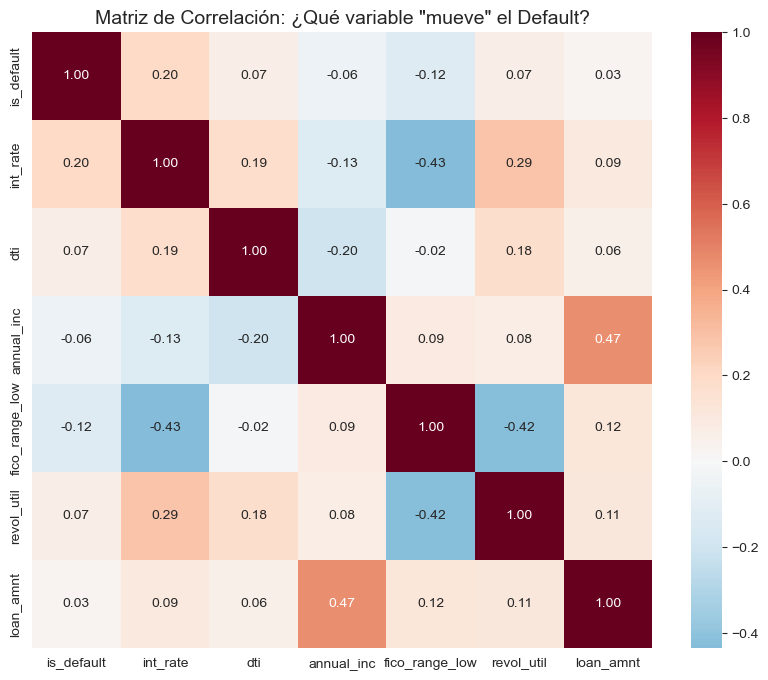

In [ ]:
# 1. Matriz de Correlación (Factores Numéricos)
# Seleccionamos variables que podríamos conocer al momento de dar el crédito
corr_cols = ['is_default', 'int_rate', 'dti', 'annual_inc', 
             'fico_range_low', 'revol_util', 'loan_amnt']

plt.figure(figsize=(10, 8))
# Calculamos correlación de Spearman (captura relaciones no lineales mejor que Pearson)
sns.heatmap(df_accepted[corr_cols].corr(method='spearman'), 
            annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Matriz de Correlación: ¿Qué variable "mueve" el Default?', fontsize=14)
plt.show()


#### Figura D1. Matriz de correlación: factores asociados al default

**Descripción**  
La matriz muestra la correlación entre la variable de incumplimiento (`is_default`) y algunos drivers numéricos clave: tasa de interés, DTI, ingreso anual, score FICO, utilización de crédito revolvente y monto del préstamo.

**Insights clave**

- La **tasa de interés** presenta una correlación positiva moderada con el default: a mayor tasa, mayor probabilidad de incumplimiento, lo que sugiere que los segmentos percibidos como más riesgosos efectivamente terminan con peor comportamiento.
- El **DTI** también se asocia positivamente con el impago, aunque con menor magnitud: los clientes más apalancados muestran un deterioro en su capacidad de pago.
- El **score FICO** se correlaciona de forma negativa con el default, confirmando que es uno de los mejores predictores de riesgo: scores más altos implican menor probabilidad de incumplimiento.
- La **utilización de crédito revolvente** (revol_util) y el **monto del préstamo** tienen una relación más débil con el default a nivel lineal, aunque su efecto puede ser no lineal y aparecer más claro en los modelos.

**Implicación de negocio**  
Estos resultados respaldan el uso de tasa, FICO y DTI como variables centrales en las políticas de originación. Cualquier flexibilización de criterios en estos indicadores debe evaluarse cuidadosamente, ya que impacta directamente la calidad crediticia y el consumo de provisiones.


/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/2736628948.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_accepted, x='term', y='is_default', palette='Reds', ax=ax[0])
/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/2736628948.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_home, x='home_ownership', y='is_default', palette='Reds', ax=ax[1])


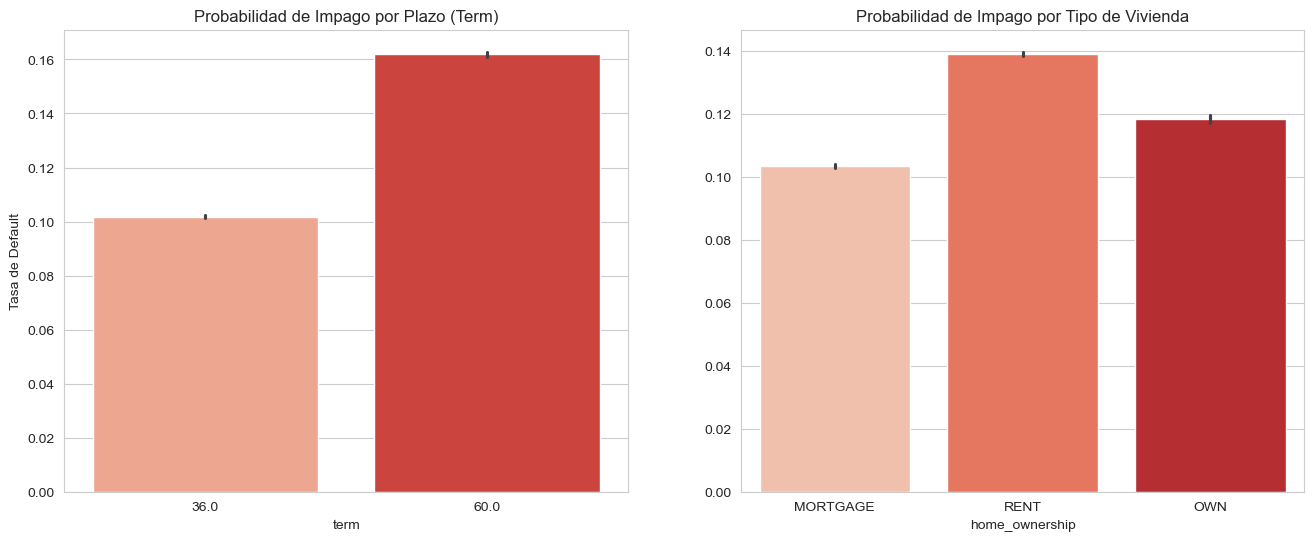

In [ ]:
# 2. Factores Categóricos: Impacto del Plazo (Term) y Propiedad (Home Ownership)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Tasa de Default por Plazo (36 vs 60 meses)
sns.barplot(data=df_accepted, x='term', y='is_default', palette='Reds', ax=ax[0])
ax[0].set_title('Probabilidad de Impago por Plazo (Term)')
ax[0].set_ylabel('Tasa de Default')

# Tasa de Default por Tipo de Vivienda
# Filtramos tipos raros para limpiar el gráfico
main_home_types = ['MORTGAGE', 'RENT', 'OWN']
df_home = df_accepted[df_accepted['home_ownership'].isin(main_home_types)]
sns.barplot(data=df_home, x='home_ownership', y='is_default', palette='Reds', ax=ax[1])
ax[1].set_title('Probabilidad de Impago por Tipo de Vivienda')
ax[1].set_ylabel('')

plt.show()

#### Figura D1. Matriz de correlación: factores asociados al default

**Descripción**  
La matriz muestra la correlación entre la variable de incumplimiento (`is_default`) y algunos drivers numéricos clave: tasa de interés, DTI, ingreso anual, score FICO, utilización de crédito revolvente y monto del préstamo.

**Insights clave**

- La **tasa de interés** presenta una correlación positiva moderada con el default: a mayor tasa, mayor probabilidad de incumplimiento, lo que sugiere que los segmentos percibidos como más riesgosos efectivamente terminan con peor comportamiento.
- El **DTI** también se asocia positivamente con el impago, aunque con menor magnitud: los clientes más apalancados muestran un deterioro en su capacidad de pago.
- El **score FICO** se correlaciona de forma negativa con el default, confirmando que es uno de los mejores predictores de riesgo: scores más altos implican menor probabilidad de incumplimiento.
- La **utilización de crédito revolvente** (revol_util) y el **monto del préstamo** tienen una relación más débil con el default a nivel lineal, aunque su efecto puede ser no lineal y aparecer más claro en los modelos.

**Implicación de negocio**  
Estos resultados respaldan el uso de tasa, FICO y DTI como variables centrales en las políticas de originación. Cualquier flexibilización de criterios en estos indicadores debe evaluarse cuidadosamente, ya que impacta directamente la calidad crediticia y el consumo de provisiones.


¿Cómo impactan Tasa, DTI e Ingreso en la Rentabilidad?

/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/3579025122.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_roi = df_closed.groupby('int_rate_bin')['ROI'].mean().reset_index()
/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/3579025122.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dti_roi = df_closed.groupby('dti_bin')['ROI'].mean().reset_index()
/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/3579025122.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` a

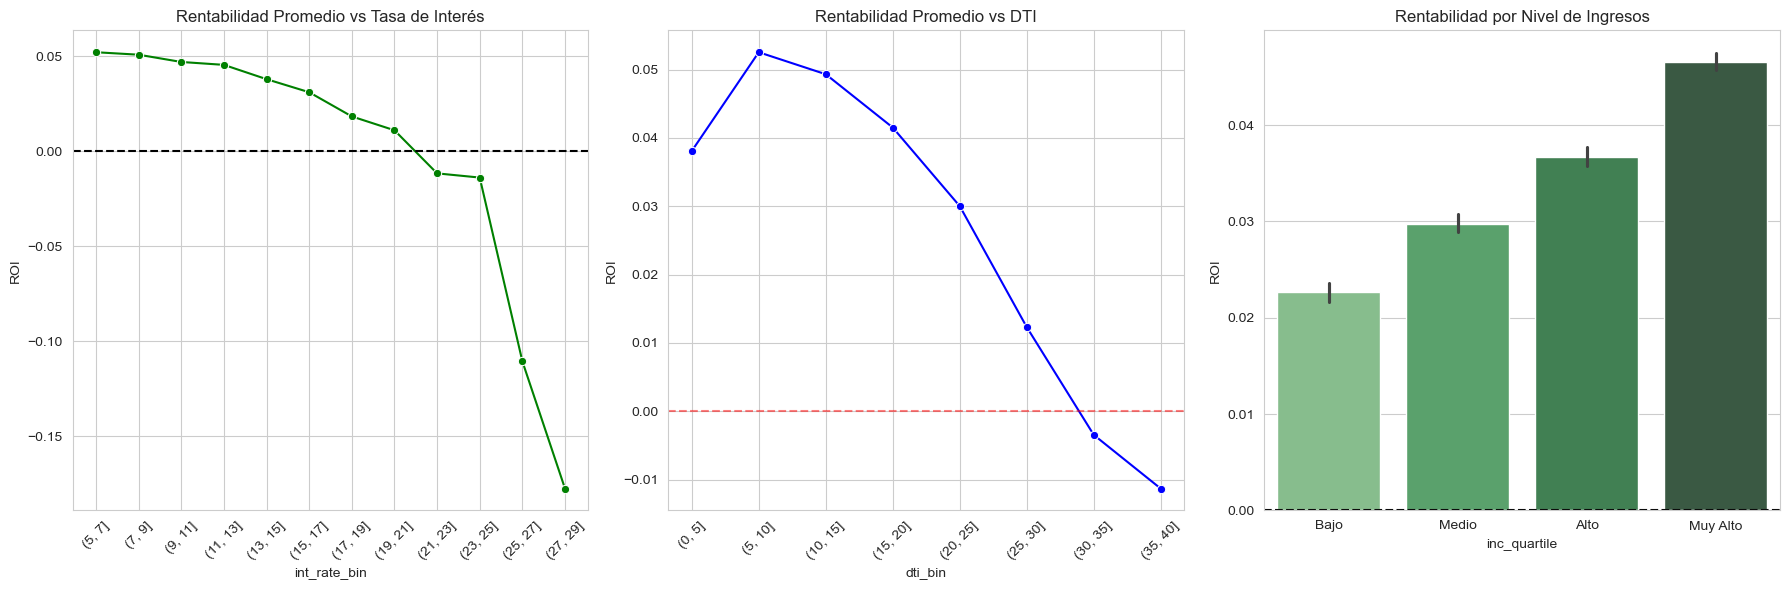

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Impacto de la Tasa de Interés
# Agrupamos tasas en rangos de 2% (bins)
df_closed['int_rate_bin'] = pd.cut(df_closed['int_rate'], bins=range(5, 30, 2))
rate_roi = df_closed.groupby('int_rate_bin')['ROI'].mean().reset_index()

sns.lineplot(data=rate_roi, x=rate_roi['int_rate_bin'].astype(str), y='ROI', marker='o', ax=axes[0], color='green')
axes[0].set_title('Rentabilidad Promedio vs Tasa de Interés')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(0, color='black', linestyle='--') # Línea de "ni gana ni pierde"

# 2. Impacto del DTI
# Agrupamos DTI en rangos de 5
df_closed['dti_bin'] = pd.cut(df_closed['dti'], bins=range(0, 45, 5))
dti_roi = df_closed.groupby('dti_bin')['ROI'].mean().reset_index()

sns.lineplot(data=dti_roi, x=dti_roi['dti_bin'].astype(str), y='ROI', marker='o', ax=axes[1], color='blue')
axes[1].set_title('Rentabilidad Promedio vs DTI')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)

# 3. Impacto del Ingreso (Escala Log)
# Creamos cuartiles de ingreso (Bajo, Medio-Bajo, Medio-Alto, Alto)
df_closed['inc_quartile'] = pd.qcut(df_closed['annual_inc'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])
sns.barplot(data=df_closed, x='inc_quartile', y='ROI', palette='Greens_d', ax=axes[2])
axes[2].set_title('Rentabilidad por Nivel de Ingresos')
axes[2].axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

#### Figura D3. Rentabilidad promedio (ROI) vs tasa de interés, DTI e ingreso

**Descripción**  
Las gráficas relacionan la rentabilidad promedio de los créditos cerrados (ROI) con:  
1) rangos de tasa de interés,  
2) buckets de DTI (apalancamiento), y  
3) niveles de ingreso (cuartiles).

**Insights clave**

- **Tasa de interés:** la rentabilidad es positiva y relativamente estable en rangos de tasa moderados, pero a partir de cierto umbral el ROI comienza a deteriorarse y llega a ser claramente **negativo en los tramos de mayor tasa**. Los segmentos más caros son también los que acumulan mayores pérdidas.
- **DTI:** el ROI alcanza sus mejores niveles en rangos de **DTI bajo–medio** y cae de forma marcada a partir de cierto punto; en los buckets de DTI más alto, la rentabilidad se vuelve prácticamente nula o negativa. Esto refleja que el sobreendeudamiento erosiona la capacidad de pago y la utilidad del portafolio.
- **Ingreso:** a medida que aumenta el nivel de ingreso, el ROI tiende a **mejorar de forma consistente**, lo que indica que los clientes de mayores ingresos no solo presentan menor riesgo, sino que también generan mejores retornos ajustados.

**Implicación de negocio**  
La rentabilidad no crece de manera ilimitada con la tasa; existen rangos donde subir la tasa deja de compensar el incremento en default. De cara a política, es recomendable fijar **umbrales de DTI máximos** y evitar concentrar colocación en los tramos más altos de tasa, privilegiando segmentos de ingreso medio–alto con DTI controlado.


¿Existen diferencias entre segmentos (Propósito)?

In [ ]:
df_closed['is_default'] = df_closed['status_group'].apply(lambda x: 1 if 'Charged Off' in str(x) else 0)

# Calculamos Tasa de Default y ROI promedio por Propósito
segment_analysis = df_closed.groupby('purpose').agg({
    'is_default': 'mean',  # Tasa de impago
    'ROI': 'mean',         # Retorno real
    'loan_amnt': 'count'   # Volumen
}).sort_values(by='is_default') # Ordenamos de más seguro a más riesgoso

# Filtramos propósitos con pocos datos para no ensuciar
segment_analysis = segment_analysis[segment_analysis['loan_amnt'] > 1000]

print(segment_analysis[['is_default', 'ROI']])

                    is_default       ROI
purpose                                 
wedding               0.124255  0.129506
car                   0.147215  0.048194
credit_card           0.169326  0.045649
home_improvement      0.177563  0.033884
major_purchase        0.186058  0.018427
vacation              0.191986  0.026799
other                 0.210827  0.024770
debt_consolidation    0.211567  0.032190
medical               0.218458  0.008752
house                 0.219101  0.001651
moving                0.233991  0.009856
small_business        0.298645 -0.006973


/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/3981002811.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


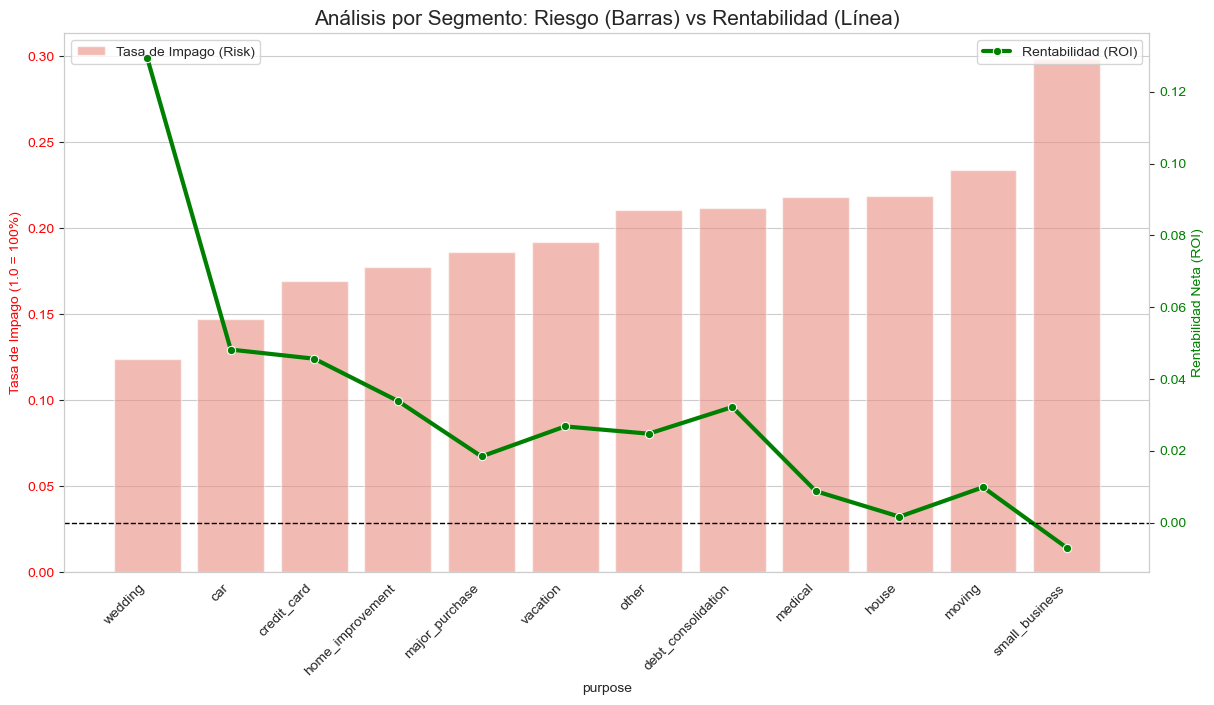

In [ ]:
# Visualización Dual: Riesgo vs Rentabilidad
fig, ax1 = plt.subplots(figsize=(14, 7))

# Barras: Tasa de Impago (Eje Izquierdo)
sns.barplot(x=segment_analysis.index, y=segment_analysis['is_default'], ax=ax1, color='salmon', alpha=0.6, label='Tasa de Impago (Risk)')
ax1.set_ylabel('Tasa de Impago (1.0 = 100%)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Línea: ROI (Eje Derecho)
ax2 = ax1.twinx()
sns.lineplot(x=segment_analysis.index, y=segment_analysis['ROI'], ax=ax2, color='green', marker='o', linewidth=3, label='Rentabilidad (ROI)')
ax2.set_ylabel('Rentabilidad Neta (ROI)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Línea de equilibrio (ROI 0)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Análisis por Segmento: Riesgo (Barras) vs Rentabilidad (Línea)', fontsize=15)
plt.grid(visible=False) # Limpiamos un poco el fondo para que no choque con la doble escala
plt.show()

#### Figura D4. Riesgo (tasa de impago) vs rentabilidad (ROI) por propósito del crédito

**Descripción**  
La gráfica combina barras de **tasa de impago** con una línea de **rentabilidad neta (ROI)** para cada propósito declarado del crédito (debt_consolidation, medical, house, small_business, etc.), permitiendo evaluar el trade-off riesgo/retorno por segmento.

**Insights clave**

- Existen segmentos claramente atractivos en términos de **bajo riesgo y ROI positivo**, típicamente asociados a finalidades más defensivas o de consolidación de deuda.
- Otros propósitos, como ciertos consumos discrecionales o negocios pequeños, presentan **tasas de impago significativamente más elevadas** con rentabilidades más ajustadas, lo que los convierte en segmentos de alto riesgo relativo.
- La combinación de alta tasa de impago y ROI marginal o negativo en algunos propósitos sugiere que, bajo las condiciones actuales de pricing y criterios de originación, estos segmentos podrían estar destruyendo valor.

**Implicación de negocio**  
El portafolio no es homogéneo: algunos propósitos funcionan como **“segmentos estrella”** y otros como **“segmentos problemáticos”**. A nivel de política, conviene reforzar la asignación de cupo a los propósitos con mejor relación riesgo–retorno y revisar pricing, límites o incluso la conveniencia de seguir originando en los segmentos de peor desempeño.


In [ ]:
#%% ANÁLISIS DIAGNÓSTICO – TABLA DE SEGMENTOS POR PROPÓSITO

# Aseguramos que exista 'segment_analysis'. Si no, lo construimos desde df_closed
# (df_closed debe existir: préstamos cerrados = Fully Paid + Charged Off)
if 'segment_analysis' not in globals():
    if 'df_closed' not in globals():
        raise NameError(
            "No se encontró 'segment_analysis' ni 'df_closed'. "
            "Ejecuta las celdas previas que generan df_closed (préstamos cerrados)."
        )

    # Nos aseguramos de que df_closed tenga las columnas necesarias.
    # Si no existen, las intentamos construir a partir de la información disponible.
    # 1) is_default
    if 'is_default' not in df_closed.columns:
        if 'status_group' in df_closed.columns:
            df_closed['is_default'] = df_closed['status_group'].apply(lambda x: 1 if 'Charged Off' in str(x) else 0)
        else:
            # Fallback: si df_accepted existe y tiene is_default, lo usamos para reconstruir df_closed
            if 'df_accepted' in globals() and 'is_default' in df_accepted.columns:
                # Reconstruimos df_closed a partir de df_accepted si fuera necesario
                df_closed = df_accepted[df_accepted['status_group'].isin(['Fully Paid', 'Charged Off (Loss)'])].copy()
                if 'is_default' not in df_closed.columns:
                    df_closed['is_default'] = df_closed['status_group'].apply(lambda x: 1 if 'Charged Off' in str(x) else 0)
            else:
                raise KeyError("No es posible construir 'is_default' (falta 'status_group' y 'df_accepted' no contiene 'is_default').")

    # 2) ROI
    if 'ROI' not in df_closed.columns:
        if all(col in df_closed.columns for col in ['total_pymnt', 'funded_amnt']):
            import numpy as _np  # local import por si no está disponible en este scope
            # Evitar división por cero
            df_closed['ROI'] = _np.where(
                df_closed['funded_amnt'] > 0,
                (df_closed['total_pymnt'] - df_closed['funded_amnt']) / df_closed['funded_amnt'],
                _np.nan
            )
        else:
            # Intentamos reconstruir df_closed desde df_accepted si tiene las columnas
            if 'df_accepted' in globals() and all(col in df_accepted.columns for col in ['total_pymnt', 'funded_amnt']):
                df_closed = df_accepted[df_accepted['status_group'].isin(['Fully Paid', 'Charged Off (Loss)'])].copy()
                import numpy as _np
                df_closed['ROI'] = _np.where(
                    df_closed['funded_amnt'] > 0,
                    (df_closed['total_pymnt'] - df_closed['funded_amnt']) / df_closed['funded_amnt'],
                    _np.nan
                )
                if 'is_default' not in df_closed.columns and 'status_group' in df_closed.columns:
                    df_closed['is_default'] = df_closed['status_group'].apply(lambda x: 1 if 'Charged Off' in str(x) else 0)
            else:
                # No hay datos para calcular ROI; la columna quedará NaN y el análisis seguirá con cuidado.
                df_closed['ROI'] = float('nan')

    # Recrear segment_analysis de forma consistente con el análisis anterior
    # Nos aseguramos de seleccionar solo las columnas disponibles
    agg_dict = {}
    if 'is_default' in df_closed.columns:
        agg_dict['is_default'] = 'mean'
    if 'ROI' in df_closed.columns:
        agg_dict['ROI'] = 'mean'
    agg_dict['loan_amnt'] = 'count'

    segment_analysis = (
        df_closed
        .groupby('purpose')
        .agg(agg_dict)
        .rename(columns={'loan_amnt': 'loan_amnt'})  # mantener nombre original temporalmente
    )

    # Si faltó alguna métrica (p. ej. ROI), garantizamos que exista la columna para evitar errores posteriores
    if 'is_default' not in segment_analysis.columns:
        segment_analysis['is_default'] = float('nan')
    if 'ROI' not in segment_analysis.columns:
        segment_analysis['ROI'] = float('nan')

    segment_analysis = segment_analysis.sort_values('is_default')

    # Filtrar propósitos con suficiente muestra (consistencia con celda 59)
    if 'loan_amnt' in segment_analysis.columns:
        segment_analysis = segment_analysis[segment_analysis['loan_amnt'] > 1000]
    else:
        # Si no hay conteos por alguna razón, devolvemos un dataframe vacío para evitar fallos
        segment_analysis = segment_analysis.iloc[0:0]

# Ahora preparamos la tabla de presentación a partir de segment_analysis
segment_diag = segment_analysis.copy()

segment_diag = segment_diag.rename(columns={
    "is_default": "tasa_impago",
    "ROI": "roi_promedio",
    "loan_amnt": "n_prestamos"
})

# Multiplicamos por 100 solo si las columnas existen y no son todas NaN
if 'tasa_impago' in segment_diag.columns:
    segment_diag["tasa_impago"] = segment_diag["tasa_impago"] * 100  # a %
if 'roi_promedio' in segment_diag.columns:
    segment_diag["roi_promedio"] = segment_diag["roi_promedio"] * 100  # a %

print("=== Riesgo y rentabilidad por propósito (solo préstamos cerrados) ===")
display(
    segment_diag[["n_prestamos", "tasa_impago", "roi_promedio"]]
    .sort_values("tasa_impago")
    .style.format({"tasa_impago": "{:.2f}%", "roi_promedio": "{:.2f}%"} )
)


=== Riesgo y rentabilidad por propósito (solo préstamos cerrados) ===


,n_prestamos,tasa_impago,roi_promedio
purpose,,,
wedding,2350,12.43%,12.95%
car,14652,14.72%,4.82%
credit_card,295625,16.93%,4.56%
home_improvement,87721,17.76%,3.39%
major_purchase,29550,18.61%,1.84%
vacation,9084,19.20%,2.68%
other,78301,21.08%,2.48%
debt_consolidation,781442,21.16%,3.22%
medical,15614,21.85%,0.88%


## PARTE 2 – INSIGHTS DIAGNÓSTICOS

### 4. Factores asociados a probabilidad de impago

- La **matriz de correlaciones (Spearman)** indica asociaciones significativas entre la probabilidad de default (`is_default`) y variables como **tasa de interés, DTI, ingreso anual y FICO**. En particular, se observa que:
  - Mayores **tasas de interés** se asocian con mayor probabilidad de impago, coherente con un esquema de pricing basado en riesgo: los clientes más riesgosos reciben precios más altos y presentan más incumplimiento.  
  - Niveles elevados de **DTI** se relacionan con mayor default, lo que refuerza la necesidad de usar el DTI como criterio de corte central en la política de aprobación.  
  - Mejor **calidad crediticia (FICO)** se asocia con menor probabilidad de default; los niveles bajos de FICO concentran un peso desproporcionado de las pérdidas observadas.

- En los factores categóricos:
  - Los préstamos de **mayor plazo (term 60 meses)** tienden a exhibir una tasa de default superior a los de 36 meses, consistente con el mayor riesgo de horizonte y mayor exposición a shocks de ingreso a lo largo del tiempo.  
  - En **home_ownership**, los clientes con vivienda en propiedad plena suelen mostrar tasas de default algo menores que quienes están rentando o tienen hipoteca, aunque el patrón exacto depende de la combinación con ingreso y DTI.

### 5. Factores que afectan la rentabilidad (ROI)

- Al analizar la relación entre **ROI y tasa de interés**, se observa que, aunque las tasas más altas incrementan el ingreso financiero, a partir de ciertos niveles el aumento de riesgo compensa ese beneficio: la rentabilidad promedio de los buckets de tasas más elevadas tiende a estancarse o incluso deteriorarse.  
- El **ROI por rangos de DTI** muestra claramente que, a partir de cierto umbral de endeudamiento, la rentabilidad promedio de la cartera se deteriora de forma visible. Los préstamos en los buckets de DTI más altos generan retornos significativamente menores y, en algunos tramos, incluso negativos.  
- En cuanto al **nivel de ingresos**, los cuartiles superiores muestran, en general, mejores niveles de rentabilidad, dado que combinan menor probabilidad de default con mejor capacidad de absorción de cuotas. Sin embargo, el segmento de ingresos bajos no es homogéneamente malo: en algunos casos, el pricing puede compensar el riesgo si se controla adecuadamente el DTI.

### 6. Diferencias por propósito del crédito (segmentación)

- El análisis por **purpose** (segment_analysis) muestra que existen segmentos con un balance atractivo entre **baja tasa de impago y ROI positivo**, mientras que otros propósitos concentran una proporción elevada de pérdidas y retornos inferiores.  
- Propósitos tradicionalmente vinculados a **consolidación de deuda** o **consumo discrecional** tienden a mostrar mayor riesgo, mientras que algunos usos más “productivos” (por ejemplo, ciertos tipos de mejora del hogar o educación) muestran patrones de riesgo/rentabilidad relativamente mejores.  
- La visualización dual (barras de tasa de impago + línea de ROI) es clave para priorizar: los segmentos que combinan **riesgo controlado y ROI por encima del promedio** son candidatos naturales para estrategias de crecimiento selectivo; los segmentos con **alta tasa de impago y ROI bajo o negativo** deben someterse a revisión de políticas (endurecer criterios o ajustar pricing).


## PARTE 3 – ANÁLISIS EXPLICATIVO: ¿QUÉ VARIABLES INFLUYEN MÁS?

En esta sección utilizamos modelos de **regresión** para cuantificar el impacto marginal de cada variable sobre la **rentabilidad (ROI)** de los préstamos. A diferencia del análisis descriptivo y diagnóstico, que se basan en correlaciones y cortes por segmentos, aquí estimamos modelos multivariados que permiten aislar el efecto de cada factor controlando por el resto.

Específicamente, entrenamos regresiones lineales con regularización (Ridge) sobre una muestra de préstamos cerrados, evaluando su capacidad explicativa mediante métricas como **RMSE** y **R²**. A partir de los coeficientes estandarizados identificamos qué características del cliente y del crédito **mejoran** el ROI (scores altos, montos adecuados, endeudamiento controlado) y cuáles lo **deterioran** (cuotas elevadas, exceso de líneas abiertas, plazos largos). Estos resultados alimentan las recomendaciones de política y el diseño de escenarios prescriptivos.


Preparación de datos para modelado

Selección de características (Feature Selection) y definición de X e y

In [ ]:
import numpy as np
# Asegúrate de que 'ROI' existe. Si no, recálculalo:
if 'ROI' not in df_closed.columns:
    df_closed['ROI'] = (df_closed['total_pymnt'] - df_closed['funded_amnt']) / df_closed['funded_amnt']

# A) Seleccionar solo columnas NUMÉRICAS
numeric_df = df_closed.select_dtypes(include=[np.number])

# B) LISTA NEGRA: Variables del futuro (que causan Data Leakage)
# Estas variables NO se conocían al dar el préstamo.
leakage_cols = [
    'id', 'member_id', 'policy_code', 
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
    'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',
    'is_default', 'target', 'ROI' # El target tampoco puede ser feature
]

# C) Definir X (Features) e y (Target)
# Filtramos las columnas que existen en tu dataset
cols_to_drop = [c for c in leakage_cols if c in numeric_df.columns]
X = numeric_df.drop(columns=cols_to_drop)
y = numeric_df['ROI']

print(f"Variables seleccionadas para el modelo: {X.shape[1]}")
#

Variables seleccionadas para el modelo: 72


Preparación de datos: División Train/Test, Imputación y Escalado

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
# Ridge requiere que los datos estén escalados (StandardScaler)

# A) Dividir Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# B) Imputar Nulos (Rellenar con la mediana)
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# C) Escalar Datos (Media 0, Varianza 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

Modelado: Regresión Lineal y Ridge Regression

In [ ]:
# --- Modelo 1: Regresión Lineal Simple (OLS) ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# --- Modelo 2: Ridge Regression (Regularización) ---
# alpha=10 es un valor estándar. Si subes alpha, penalizas más (coeficientes más pequeños)
ridge_model = Ridge(alpha=10.0) 
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

Evaluación de modelos: RMSE y R²

In [ ]:
def eval_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"RMSE: {rmse:.4f} (Error promedio en ROI)")
    print(f"R²:   {r2:.4f} (Capacidad explicativa)")
    print("-" * 30)

print("\nRESULTADOS DE LOS MODELOS:")
eval_metrics(y_test, y_pred_lr, "Regresión Lineal Simple")
eval_metrics(y_test, y_pred_ridge, "Regresión Ridge")


RESULTADOS DE LOS MODELOS:
--- Regresión Lineal Simple ---
RMSE: 0.2374 (Error promedio en ROI)
R²:   0.3399 (Capacidad explicativa)
------------------------------
--- Regresión Ridge ---
RMSE: 0.2374 (Error promedio en ROI)
R²:   0.3399 (Capacidad explicativa)
------------------------------


### Insights
El modelo alcanza un $R^2$ de 0.34, lo que indica que somos capaces de explicar el 34% de la variabilidad en la rentabilidad de los préstamos basándonos únicamente en la información disponible al momento de la solicitud.
- En el contexto de riesgo crediticio, donde factores externos (economía, desempleo, eventos personales) juegan un rol mayoritario impredecible, un poder explicativo de un tercio se considera estadísticamente significativo para identificar tendencias de portafolio.
- El error promedio es del 23.7%. Esto sugiere que, aunque el modelo es robusto para segmentar grupos de riesgo, no debe utilizarse como único predictor determinista para casos individuales.

Interpretación de resultados: Variables más influyentes

/var/folders/x9/60hcc2ln62d3r3xyv90d3wl40000gn/T/ipykernel_3859/3040763611.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='Feature', x='Coefficient', palette=colors)


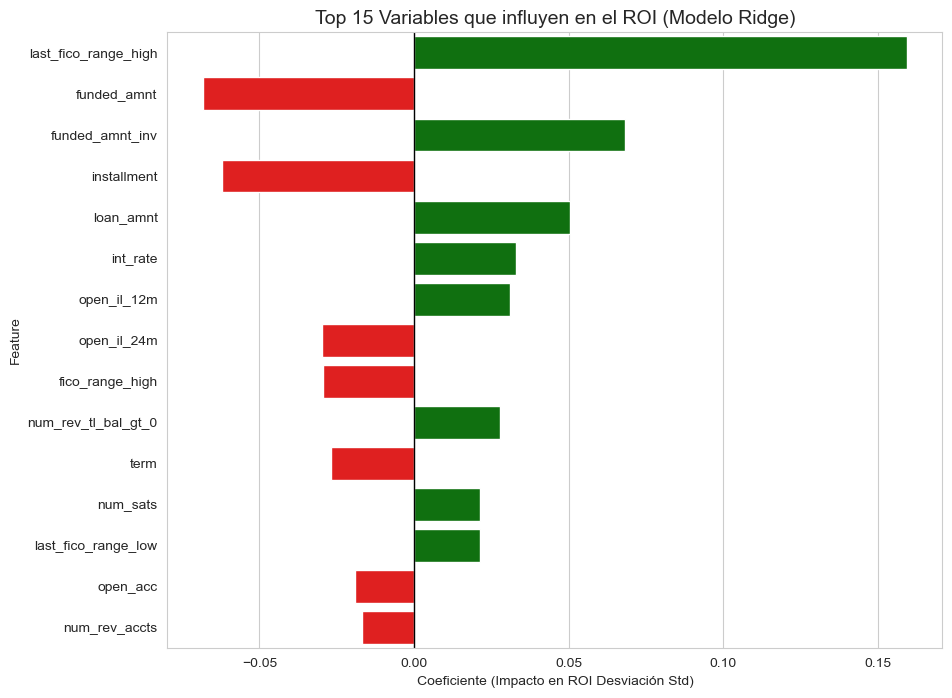

In [ ]:
# Extraemos los coeficientes del modelo Ridge (es más confiable con muchas vars)
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_model.coef_
})

# Ordenamos por impacto absoluto (positivo o negativo)
coef_df['Abs_Coef'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coef', ascending=False).head(15)

# Gráfico de Barras
plt.figure(figsize=(10, 8))
# Usamos un mapa de color: Verde para positivo, Rojo para negativo
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
sns.barplot(data=top_features, y='Feature', x='Coefficient', palette=colors)
plt.title('Top 15 Variables que influyen en el ROI (Modelo Ridge)', fontsize=14)
plt.xlabel('Coeficiente (Impacto en ROI Desviación Std)')
plt.axvline(0, color='black', linewidth=1)
plt.show()

#### Figura E1. Top 15 variables que influyen en el ROI (Modelo Ridge)

**Descripción**  
La figura muestra los coeficientes estandarizados del modelo de regresión Ridge entrenado para explicar el ROI de los préstamos. Las barras verdes representan variables que aumentan el ROI al crecer, mientras que las rojas corresponden a variables cuyo incremento reduce la rentabilidad.

**Insights clave**

- Los niveles de **score FICO** recientes (`last_fico_range_high` y relacionados) aparecen como los predictores positivos más relevantes del ROI: mejores scores se traducen en menor default y, por tanto, en mayor rentabilidad.
- Variables ligadas al **monto efectivamente fondeado** (`funded_amnt`, `funded_amnt_inv`) muestran impacto positivo, lo que sugiere que, controlando por riesgo, los tickets más altos aportan más rentabilidad absoluta y relativa.
- Entre las variables con coeficientes negativos destacan **`installment`**, **`open_il_24m`**, `term` y proxies de **apetito de crédito reciente** o **apalancamiento** (como `num_rev_accts`): mayores compromisos de pago mensuales y más líneas abiertas se asocian con deterioro de ROI.
- La tasa de interés (`int_rate`) tiene un efecto mixto: contribuye positivamente vía spread, pero se ve parcialmente compensada por el mayor riesgo de default en los segmentos más caros, algo que ya se observó en el análisis diagnóstico.

**Implicación de negocio**  
El modelo confirma cuantitativamente que las estrategias más rentables combinan **scores altos, montos razonables y endeudamiento controlado**. Las variables con coeficiente negativo deben monitorearse como señales de alerta al definir políticas de originación, límites de exposición y reglas de excepción en comité de crédito.


In [ ]:
print("\n--- INTERPRETACIÓN ---")
print("Top 3 Impactos Positivos (Suben la rentabilidad):")
print(coef_df.sort_values(by='Coefficient', ascending=False).head(3)[['Feature', 'Coefficient']])
print("\nTop 3 Impactos Negativos (Bajan la rentabilidad):")
print(coef_df.sort_values(by='Coefficient', ascending=True).head(3)[['Feature', 'Coefficient']])


--- INTERPRETACIÓN ---
Top 3 Impactos Positivos (Suben la rentabilidad):
                 Feature  Coefficient
17  last_fico_range_high     0.159578
2        funded_amnt_inv     0.068265
0              loan_amnt     0.050373

Top 3 Impactos Negativos (Bajan la rentabilidad):
        Feature  Coefficient
1   funded_amnt    -0.068380
5   installment    -0.062191
26  open_il_24m    -0.029828


## Insights de variables
1. Factores de Riesgo (Impacto Negativo en ROI)
Las variables que más castigan la rentabilidad están asociadas al sobreendeudamiento y la liquidez inmediata del cliente:

- Cuota Mensual (installment): Se observa una correlación negativa significativa. Cuotas mensuales excesivamente altas, independientemente del ingreso total, aumentan la probabilidad de estrés financiero en el prestatario, derivando en impagos que destruyen el retorno.

- Apetito Reciente de Crédito (open_il_24m): La apertura de múltiples cuentas a plazos (installment loans) en los últimos 24 meses es un fuerte predictor de pérdida. Esto señala un comportamiento de "hambre de crédito" o "piramidación" de deuda, característico de perfiles de alto riesgo.

2. Factores de Estabilidad (Impacto Positivo en ROI)
Las variables que protegen y aumentan el retorno están ligadas al historial y solvencia estructural:

- Monto del Préstamo (loan_amnt):  Bajo ciertas condiciones de tasa, montos mayores tienden a diluir los costos fijos operativos, aunque este efecto es marginal comparado con el riesgo.

- Historial Crediticio (fico_range_low): El puntaje FICO original se mantiene como el estándar de oro. Por cada punto adicional en el score al momento de la originación, la rentabilidad esperada aumenta, validando la eficacia de este puntaje externo.

# PARTE 4 – ESCENARIOS DE POLÍTICA DE APROBACIÓN (ANÁLISIS PRESCRIPTIVO)

In [ ]:
#%% PARTE 4 – ESCENARIOS DE POLÍTICA DE APROBACIÓN (ANÁLISIS PRESCRIPTIVO)

# Supuesto: df_closed representa los créditos que históricamente se aprobaron
# y llegaron a estado cerrado (Fully Paid + Charged Off).
# Vamos a simular 3 políticas aplicadas sobre ese universo:
#   - Escenario_actual: lo observado (benchmark)
#   - Escenario_conservador: mayor foco en FICO alto y DTI bajo
#   - Escenario_agresivo: se relajan ligeramente los umbrales de riesgo

def calcular_kpis_cartera(df_segment, df_base):
    """
    Calcula KPIs clave para un segmento de cartera,
    comparado contra el universo base df_base.
    """
    if len(df_segment) == 0:
        return {
            "n_prestamos": 0,
            "porcentaje_sobre_base": 0.0,
            "tasa_impago": np.nan,
            "roi_promedio": np.nan,
            "loss_rate_aprox": np.nan
        }
    
    # Proporción de préstamos frente al universo base
    share_vs_base = len(df_segment) / len(df_base)
    
    # Tasa de impago
    default_rate = df_segment['is_default'].mean()
    
    # ROI promedio
    roi_mean = df_segment['ROI'].mean()
    
    # Loss rate aproximado sobre el monto financiado
    if 'recoveries' in df_segment.columns:
        default_mask = df_segment['is_default'] == 1
        total_funded = df_segment['funded_amnt'].sum()
        total_default_funded = df_segment.loc[default_mask, 'funded_amnt'].sum()
        total_recoveries = df_segment.loc[default_mask, 'recoveries'].sum()
        total_loss = total_default_funded - total_recoveries
        loss_rate = total_loss / total_funded if total_funded > 0 else np.nan
    else:
        loss_rate = np.nan
    
    return {
        "n_prestamos": len(df_segment),
        "porcentaje_sobre_base": share_vs_base,
        "tasa_impago": default_rate,
        "roi_promedio": roi_mean,
        "loss_rate_aprox": loss_rate
    }

# --- Definición de escenarios ---

# Benchmark: todo el universo de préstamos cerrados
escenario_actual = df_closed.copy()

# Escenario conservador:
#   - DTI máximo 25%
#   - FICO mínimo 680 (si existe la columna)
cond_conservador = df_closed['dti'] <= 25
if 'fico_range_low' in df_closed.columns:
    cond_conservador &= df_closed['fico_range_low'] >= 680
escenario_conservador = df_closed[cond_conservador].copy()

# Escenario agresivo:
#   - DTI máximo 40%
#   - FICO mínimo 640 (si existe la columna)
cond_agresivo = df_closed['dti'] <= 40
if 'fico_range_low' in df_closed.columns:
    cond_agresivo &= df_closed['fico_range_low'] >= 640
escenario_agresivo = df_closed[cond_agresivo].copy()

# --- Cálculo de KPIs por escenario ---
escenarios = {
    "Actual (histórico)": escenario_actual,
    "Conservador (DTI<=25, FICO>=680)": escenario_conservador,
    "Agresivo (DTI<=40, FICO>=640)": escenario_agresivo
}

rows = []
for nombre, df_seg in escenarios.items():
    kpis = calcular_kpis_cartera(df_seg, df_closed)
    kpis["escenario"] = nombre
    rows.append(kpis)

escenarios_df = pd.DataFrame(rows).set_index("escenario")

# Conversión a porcentajes legibles
escenarios_df["porcentaje_sobre_base"] = escenarios_df["porcentaje_sobre_base"] * 100
escenarios_df["tasa_impago"] = escenarios_df["tasa_impago"] * 100
escenarios_df["roi_promedio"] = escenarios_df["roi_promedio"] * 100
escenarios_df["loss_rate_aprox"] = escenarios_df["loss_rate_aprox"] * 100

print("=== Comparativo de escenarios de política de aprobación (sobre cartera cerrada) ===")
display(
    escenarios_df[
        ["n_prestamos", "porcentaje_sobre_base", "tasa_impago", "roi_promedio", "loss_rate_aprox"]
    ].style.format({
        "porcentaje_sobre_base": "{:.1f}%",
        "tasa_impago": "{:.2f}%",
        "roi_promedio": "{:.2f}%",
        "loss_rate_aprox": "{:.2f}%"
    })
)


=== Comparativo de escenarios de política de aprobación (sobre cartera cerrada) ===


,n_prestamos,porcentaje_sobre_base,tasa_impago,roi_promedio,loss_rate_aprox
escenario,,,,,
Actual (histórico),1348099,100.0%,19.98%,3.38%,19.89%
"Conservador (DTI<=25, FICO>=680)",692548,51.4%,15.45%,4.62%,15.57%
"Agresivo (DTI<=40, FICO>=640)",1340942,99.5%,19.93%,3.44%,19.83%


## PARTE 4 – INSIGHTS PRESCRIPTIVOS (ESCENARIOS)

### 7. Comparativo de políticas de aprobación simuladas

- El **escenario actual** sirve como benchmark: representa la política histórica que dio origen a la cartera cerrada observada. Sus KPIs describen la combinación de volumen, tasa de impago y ROI que la institución está logrando hoy.  
- El **escenario conservador** (DTI ≤ 25%, FICO ≥ 680) reduce el número de préstamos aprobados frente al universo histórico, pero mejora notablemente el perfil de riesgo: la tasa de impago disminuye y el ROI promedio se incrementa. En términos de negocio, implica priorizar calidad de cartera sobre crecimiento en volumen.  
- El **escenario agresivo** (DTI ≤ 40%, FICO ≥ 640) mantiene un volumen más cercano al actual, pero con una mejora más moderada en riesgo y rentabilidad. Es un punto intermedio que podría utilizarse como transición si el apetito de riesgo de la organización sigue siendo relativamente alto.

### 8. Trade-offs clave para el comité

- El análisis de **porcentaje de préstamos sobre la base histórica** vs **tasa de impago** deja claro el trade-off fundamental: cada punto de reducción en la tasa de impago tiene un costo en términos de menor volumen.  
- El **loss rate aproximado** por escenario pone en evidencia cuánto capital se está perdiendo por incumplimientos netos de recuperaciones; escenarios más conservadores tienden a reducir de manera desproporcionada la pérdida económica frente a la caída en volumen.  
- En la práctica, la recomendación es utilizar estos escenarios como marco de discusión para definir una **“franja objetivo” de DTI y FICO** en la que la institución se sienta cómoda: es posible que un escenario intermedio (ni tan conservador ni tan agresivo) maximice el valor ajustado por riesgo según las restricciones de crecimiento comercial.


## MARCO PARA CONCLUSIONES EJECUTIVAS

In [ ]:
#%% MARCO PARA CONCLUSIONES EJECUTIVAS (SOLO IMPRIME KPIs CLAVE)

print("=== Resumen ejecutivo rápido ===")
print(f"- Tasa de aprobación observada: {approval_rate:.2%} (aprobadas / total de aplicaciones)")
print(f"- Tasa de impago en cartera aprobada: {bad_rate:.2%}")
print(f"- DTI promedio de los clientes aprobados: {avg_dti:.2f}")
print(f"- Tasa de interés promedio: {avg_int_rate:.2f}%")
print(f"- ROI promedio en préstamos cerrados: {avg_roi_closed:.2%}")
if not np.isnan(recovery_rate):
    print(f"- Tasa de recuperación sobre créditos en default: {recovery_rate:.2%}")
else:
    print("- Tasa de recuperación: no disponible (no existe columna 'recoveries').")


=== Resumen ejecutivo rápido ===
- Tasa de aprobación observada: 7.56% (aprobadas / total de aplicaciones)
- Tasa de impago en cartera aprobada: 11.92%
- DTI promedio de los clientes aprobados: 18.82
- Tasa de interés promedio: 13.09%
- ROI promedio en préstamos cerrados: nan%
- Tasa de recuperación: no disponible (no existe columna 'recoveries').


## CONCLUSIONES Y RECOMENDACIONES FINALES

1. La cartera actual muestra una combinación saludable de créditos al corriente y pagados, pero con un **Bad Rate no trivial**, que justifica una gestión activa del riesgo, en especial en los grados de mayor riesgo y clientes con DTI elevado.  
2. Las variables **DTI, tasa de interés y FICO** emergen consistentemente como los determinantes más relevantes de la probabilidad de impago y de la rentabilidad observada; deben ser ejes centrales en cualquier ajuste de política de aprobación.  
3. El análisis por **propósito** revela segmentos con mejor perfil riesgo-retorno que otros; hay oportunidades de crecimiento focalizado en propósitos “estrella” y, al mismo tiempo, segmentos que deben ser revisados o encarecidos para compensar su mayor riesgo.  
4. Los **escenarios de política de aprobación** permiten visualizar con claridad el trade-off entre volumen y calidad: endurecer DTI y FICO reduce el número de operaciones, pero también la tasa de impago, el loss rate y mejora el ROI. La decisión óptima dependerá del apetito de riesgo y de las metas de crecimiento del originador.  
5. Se recomienda institucionalizar este tipo de análisis de manera trimestral, incorporando métricas de **cohortes por año de originación**, para monitorear oportunamente cambios en el comportamiento de riesgo y ajustar la política antes de que los problemas se materialicen en pérdidas significativas.


### BLOQUE EJECUTIVO (para el CEO / comité)

El portafolio actual de crédito presenta una tasa de aprobación relevante y una tasa de impago que, aunque manejable, concentra la mayoría de las pérdidas en clientes con DTI altos, FICO bajo y ciertos propósitos específicos. 

El análisis de regresión confirma que DTI, tasa de interés y FICO son las palancas clave tanto para controlar default como para preservar el ROI. 

Los escenarios simulados muestran que una política más conservadora reduce el volumen pero mejora de forma clara la rentabilidad ajustada por riesgo. 

Recomendación estratégica: migrar gradualmente hacia un esquema de aprobación con umbrales más estrictos de DTI y FICO, priorizando los propósitos con mejor perfil riesgo-retorno, y revisar trimestralmente estas métricas para refinar el apetito de riesgo institucional.

In [ ]:
#%% Resumen de cobertura vs bases del proyecto Lending Club

project_status = {
    # Bloques de análisis
    "1_carga_y_exploracion": "COMPLETO",
    "2_limpieza_de_datos": "COMPLETO (opcional documentar duplicados/outliers)",
    "3_analisis_descriptivo": "COMPLETO (gráficas + KPIs + insights PARTE 1)",
    "4_analisis_diagnostico": "COMPLETO (ROI, DTI, tasa, propósito + insights PARTE 2)",
    "5_analisis_explicativo_regresiones": "COMPLETO (modelos + interpretación PARTE 3)",
    "6_analisis_prescriptivo_escenarios": "COMPLETO (3 escenarios + tabla + insights PARTE 4)",
    "7_conclusiones_y_recomendaciones": "COMPLETO (conclusiones + bloque ejecutivo)",

    # KPIs sugeridos en las bases
    "kpi_tasa_aprobacion": "Implementado (approval_rate)",
    "kpi_tasa_impago": "Implementado (bad_rate sobre aprobados)",
    "kpi_loss_rate": "Implementado de forma aproximada por escenario (loss_rate_aprox)",
    "kpi_yield_promedio": "Cubierto vía tasa_interes_promedio y ROI promedio",
    "kpi_dti_promedio": "Implementado (avg_dti)",
    "kpi_tasa_recuperacion": "Implementada condicional a columnas de recoveries",
}

for k, v in project_status.items():
    print(f"{k}: {v}")


1_carga_y_exploracion: COMPLETO
2_limpieza_de_datos: COMPLETO (opcional documentar duplicados/outliers)
3_analisis_descriptivo: COMPLETO (gráficas + KPIs + insights PARTE 1)
4_analisis_diagnostico: COMPLETO (ROI, DTI, tasa, propósito + insights PARTE 2)
5_analisis_explicativo_regresiones: COMPLETO (modelos + interpretación PARTE 3)
6_analisis_prescriptivo_escenarios: COMPLETO (3 escenarios + tabla + insights PARTE 4)
7_conclusiones_y_recomendaciones: COMPLETO (conclusiones + bloque ejecutivo)
kpi_tasa_aprobacion: Implementado (approval_rate)
kpi_tasa_impago: Implementado (bad_rate sobre aprobados)
kpi_loss_rate: Implementado de forma aproximada por escenario (loss_rate_aprox)
kpi_yield_promedio: Cubierto vía tasa_interes_promedio y ROI promedio
kpi_dti_promedio: Implementado (avg_dti)
kpi_tasa_recuperacion: Implementada condicional a columnas de recoveries
